In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+0374c0674c 	w_latest current w_2021_21 setup


In [2]:
import numpy
import pylab

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from lsst.obs.lsst import LsstCam
from lsst.cp.pipe import BrighterFatterKernelSolveTask    

In [3]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"
butler = Butler(repo_path)
#collections = "/calib/run_12781_v3"
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work/ptcs/20210610T163510Z'.split(",") ## the original PTC, Astier EXA...
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v3/ptcs/20210619T212901Z'.split(",") ## POLYNOMIAL
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v4/ptcs/20210620T164944Z'.split(",") ## FULL COVARIANCE
collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v5/ptcs/20210620T231305Z'.split(",") ## EXPAPPROXIMATION again

where = """
instrument='LSSTCam'
and detector = 29
and exposure.observation_type = 'flat'
"""
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections,where = where))
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )


114 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
72 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
114 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
114 DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrument, detector}, ExposureF, isCalib

In [4]:
def mkplot(bfk, meta=None):
    numpy.seterr(divide = 'ignore') 
    for ch in range(16):
        fig, axs = pylab.subplots(1, 5, figsize=(20,5),facecolor='w')
        for i,(akey,label,sign,func) in enumerate([
            ("MEAN_XCORRS","COVARIANCE",-1, numpy.vectorize(lambda x: numpy.log10(abs(x))) ),
            ("KERNEL","KERNEL",1, numpy.vectorize(lambda x: x))
        ]):
            pixtable = bfk.getDict()["outputBFK"].toTable()[0][akey][ch]
            axs[0+2*i].set_title(label)
            axs[0+2*i].imshow(func(pixtable.reshape(17,17)))
            axs[1+2*i].plot(pixtable.reshape(17,17)[:,8]*sign,color="blue",drawstyle='steps-mid')
            axs[1+2*i].plot(pixtable.reshape(17,17)[8,:]*sign,color="red",drawstyle='steps-mid',linestyle='--')
            axs[1+2*i].grid()
            fig.suptitle("{} {}".format(meta, ch))

        i=2*i+2
        line=bfk.getDict()["outputBFK"].toTable()[0][ch]
        x = line["MEANS"]
        y = line["VARIANCES"]
        axs[i].set_xlabel("MEANS")
        axs[i].set_ylabel("VARIANCES")    
        axs[i].plot(x,y,"o")
        xarr = numpy.arange(numpy.nanmin(x),numpy.nanmax(x))
        axs[i].plot(xarr, line["NOISE"]+xarr/line["GAIN"])
        axs[i].loglog()
        axs[i].set_title( "G={:.3} noise={:.3}".format(line["GAIN"], line["NOISE"]) )
        fig.tight_layout()
        fig.show()
    numpy.seterr(divide = 'warn')

# With new parameter

{instrument: 'LSSTCam', detector: 29, exposure: 3020111900001, ...}
{instrument: 'LSSTCam', detector: 28, exposure: 3020111900001, ...}


<ipython-input-4-9156dcff43d4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = pylab.subplots(1, 5, figsize=(20,5),facecolor='w')


{instrument: 'LSSTCam', detector: 96, exposure: 3020111900001, ...}


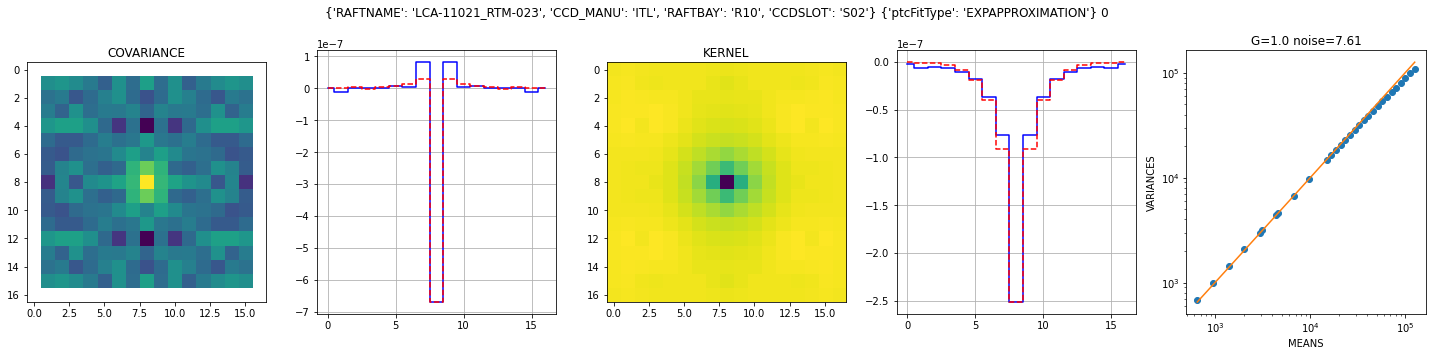

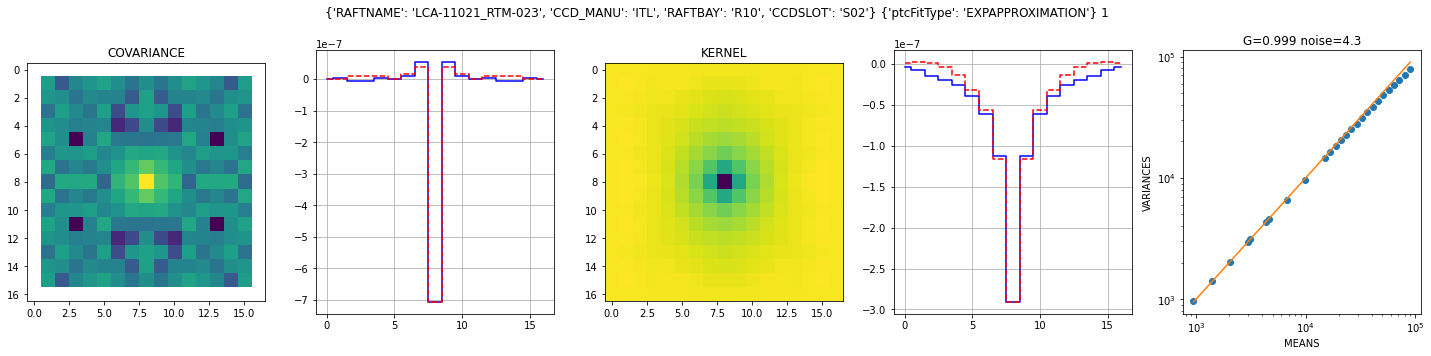

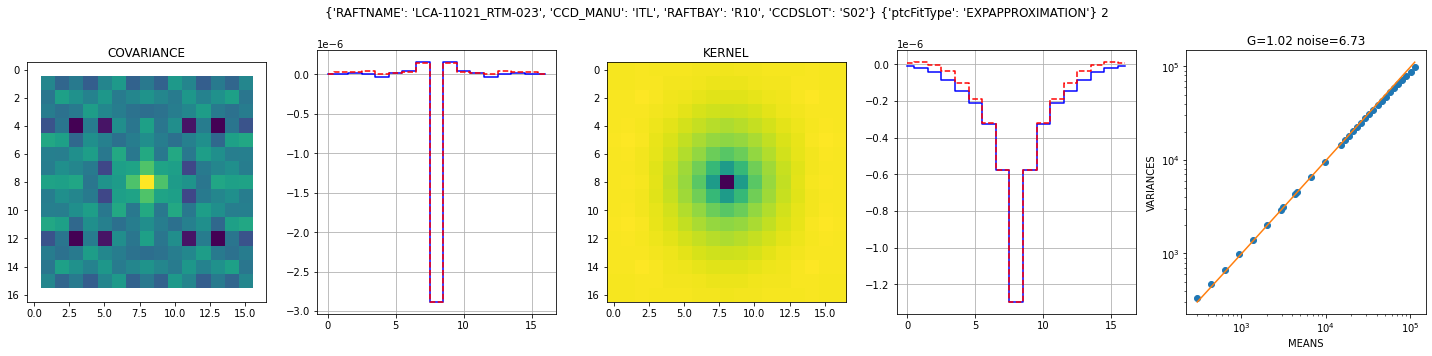

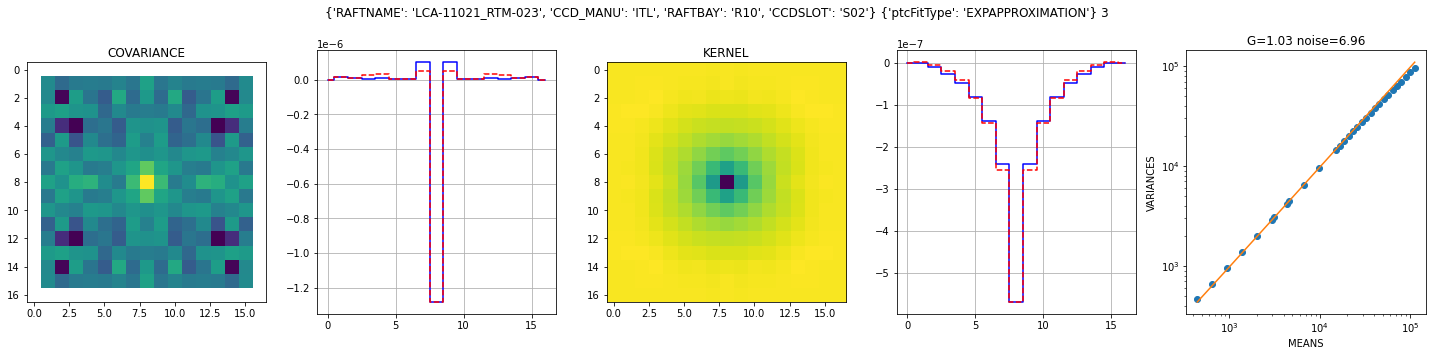

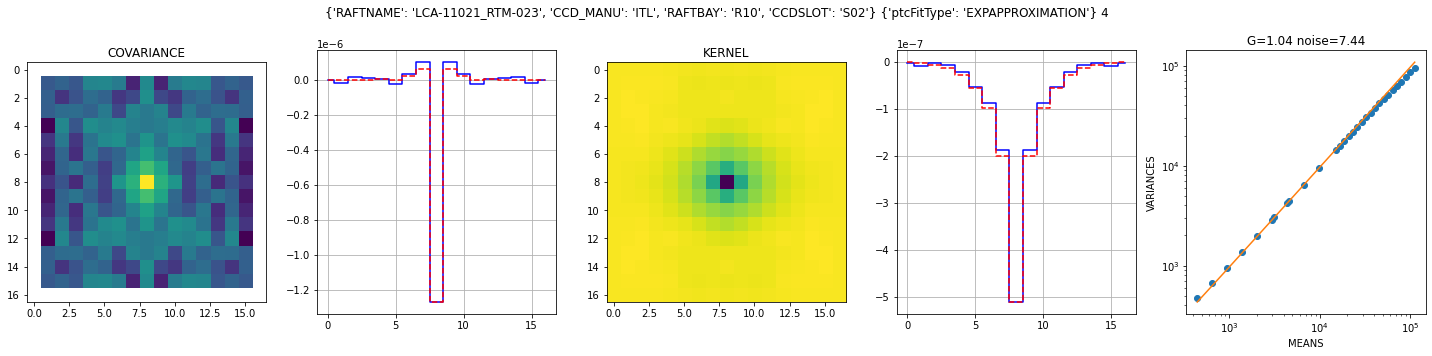

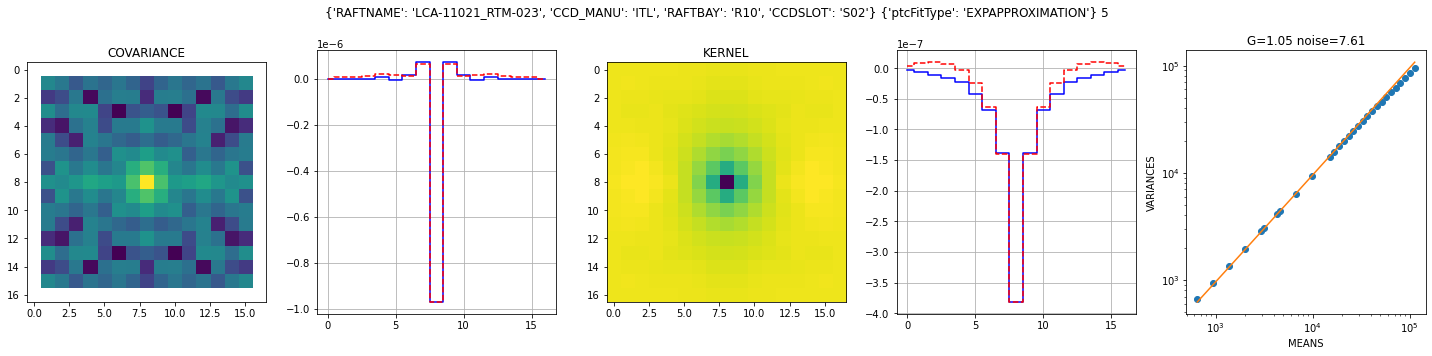

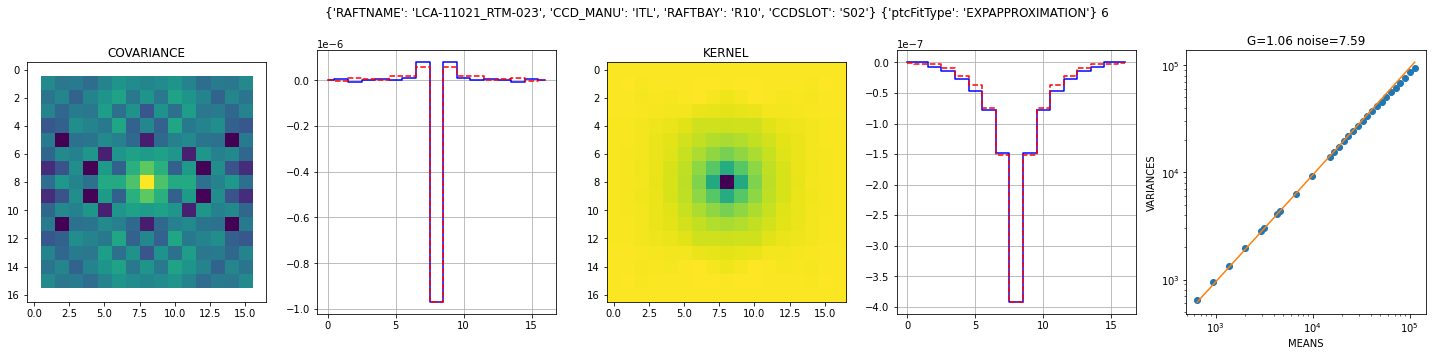

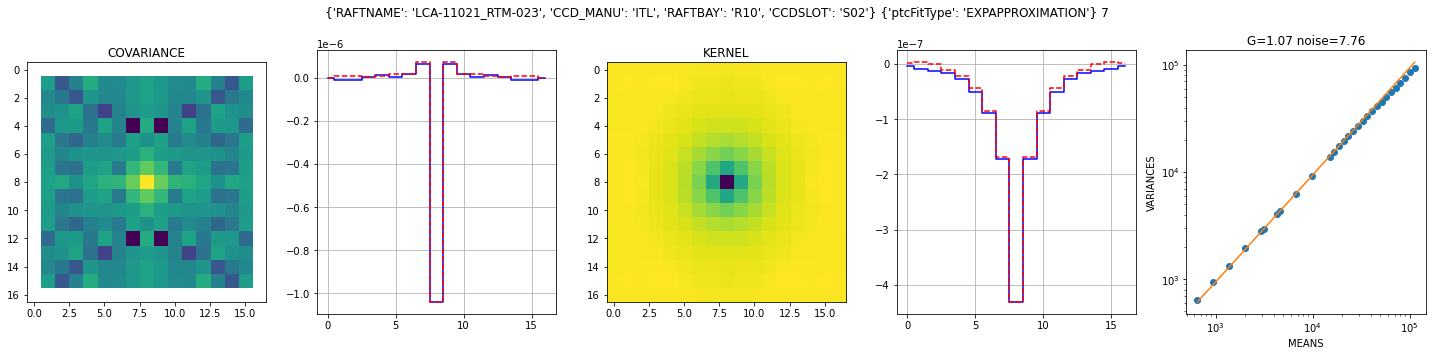

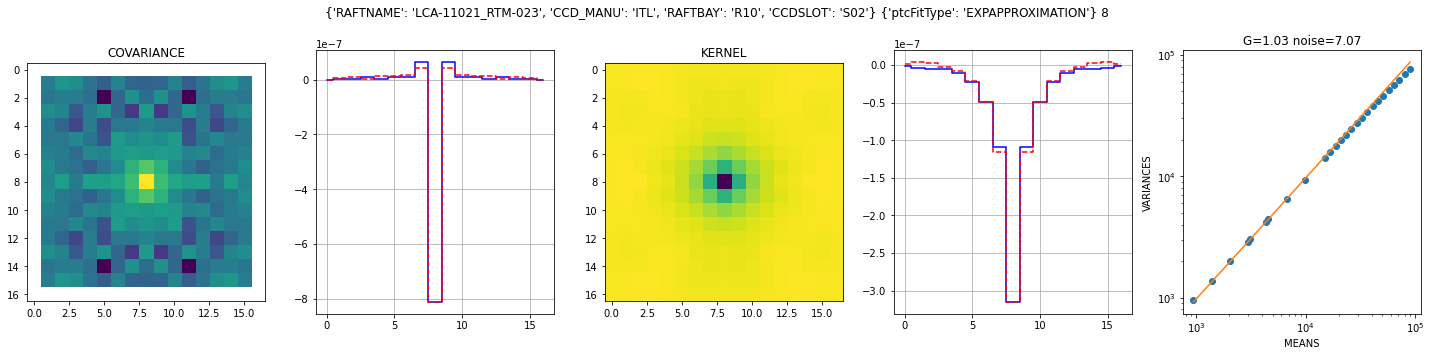

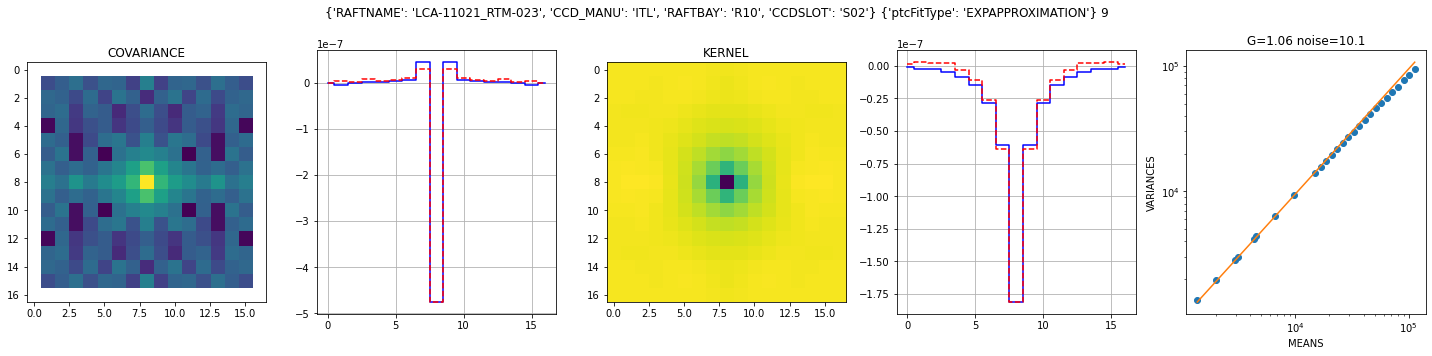

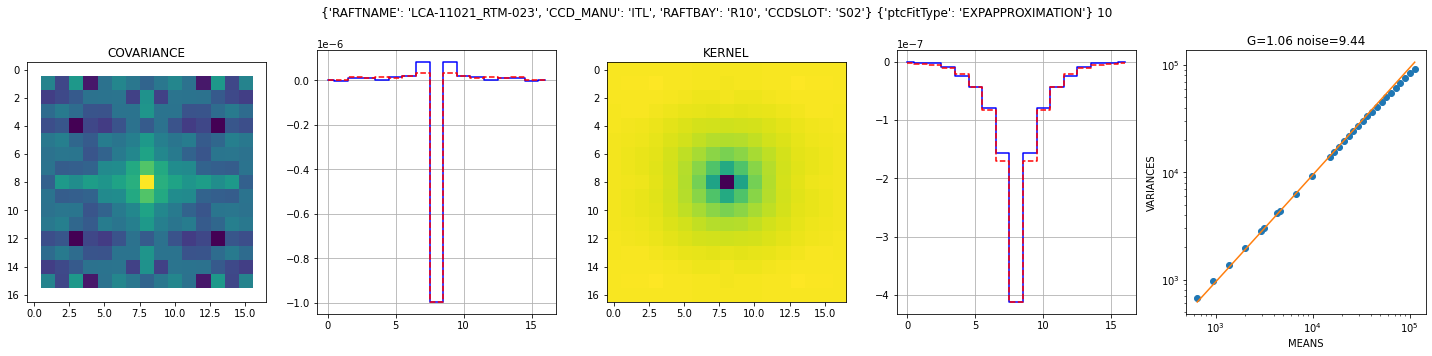

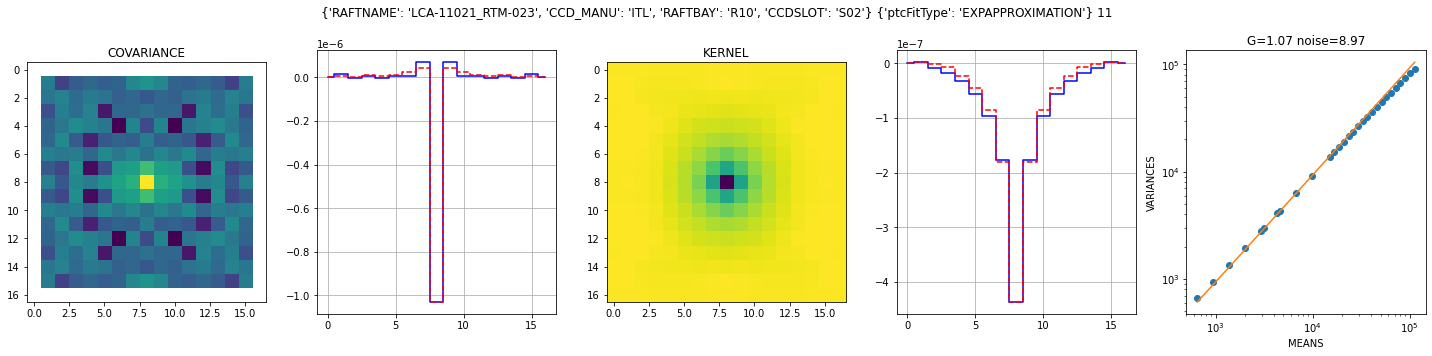

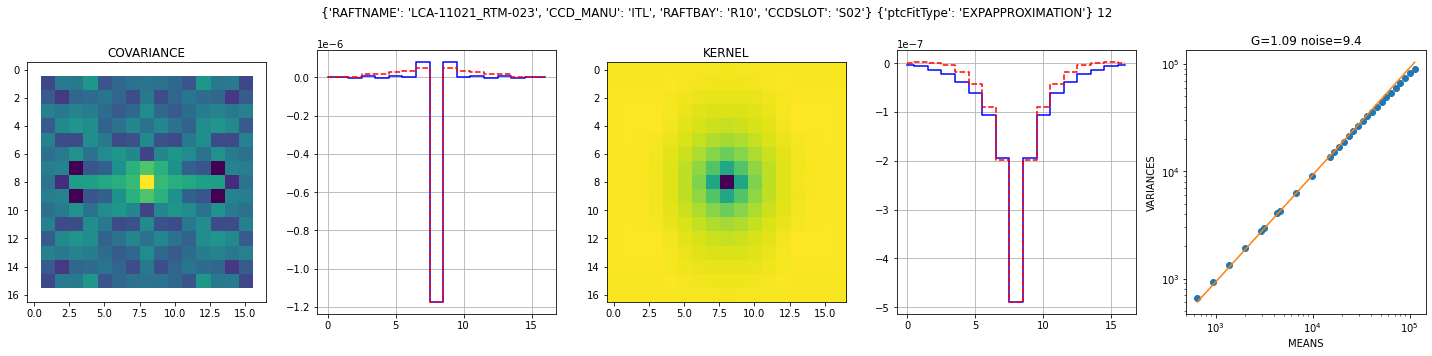

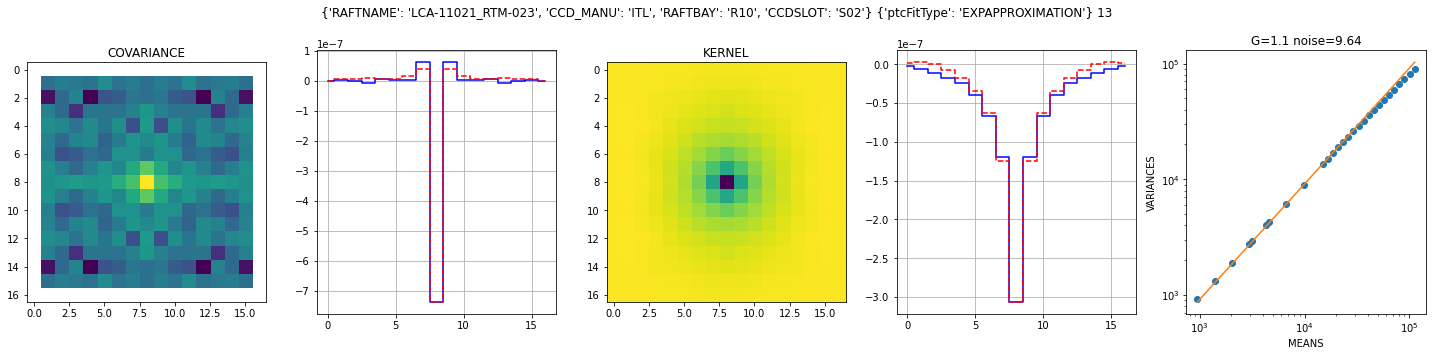

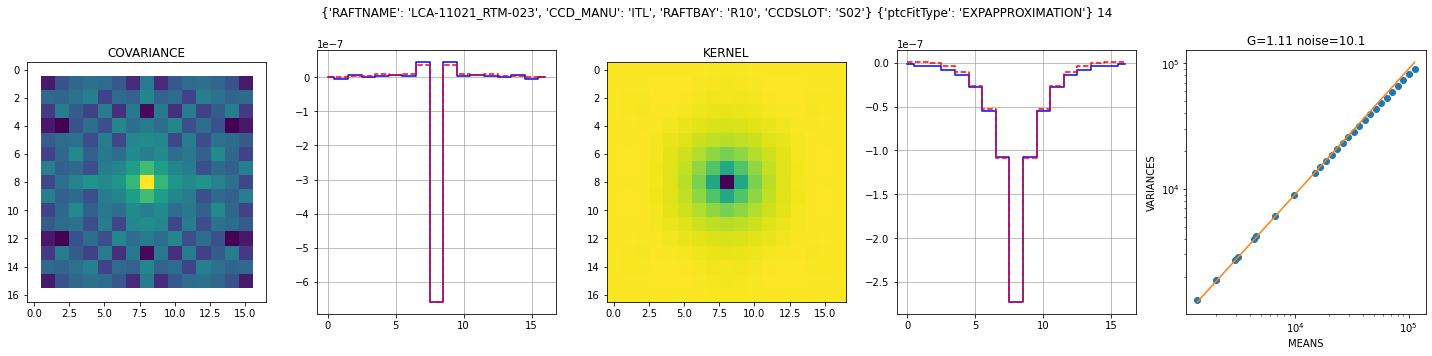

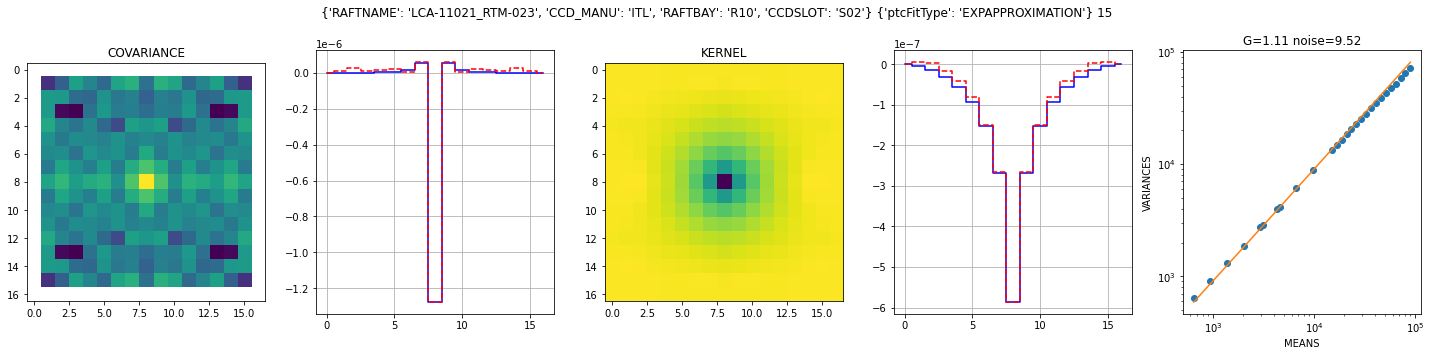

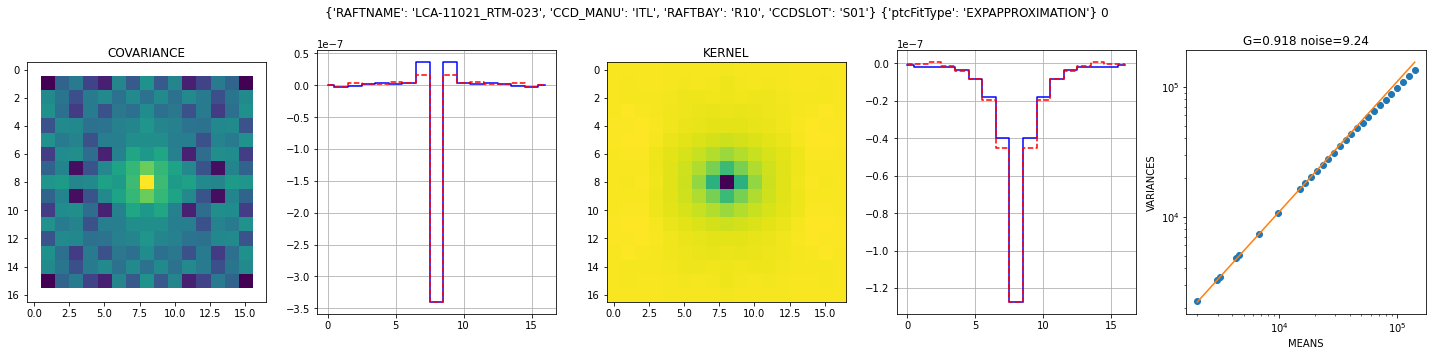

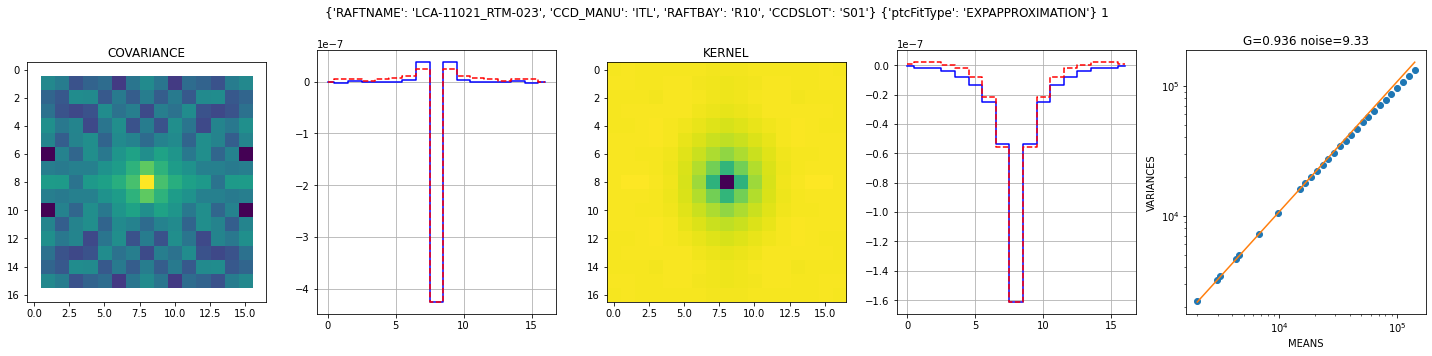

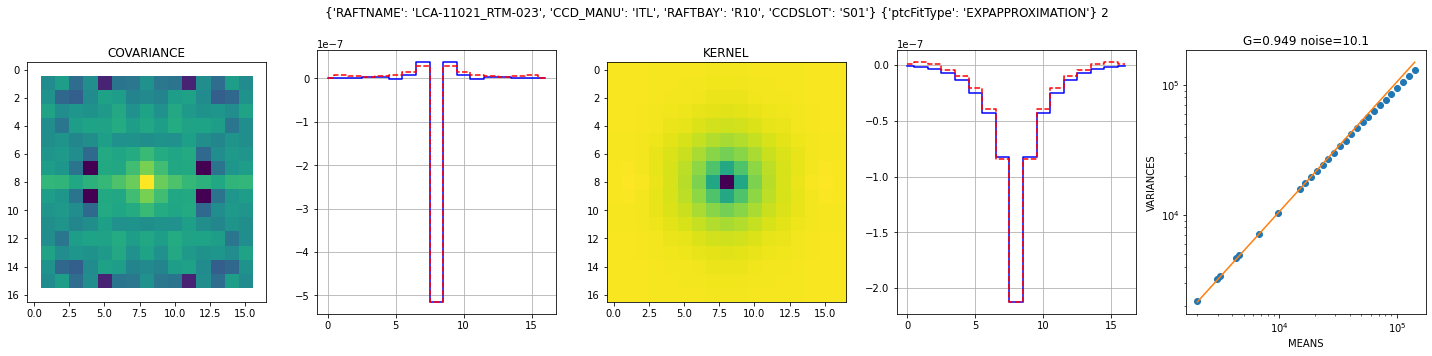

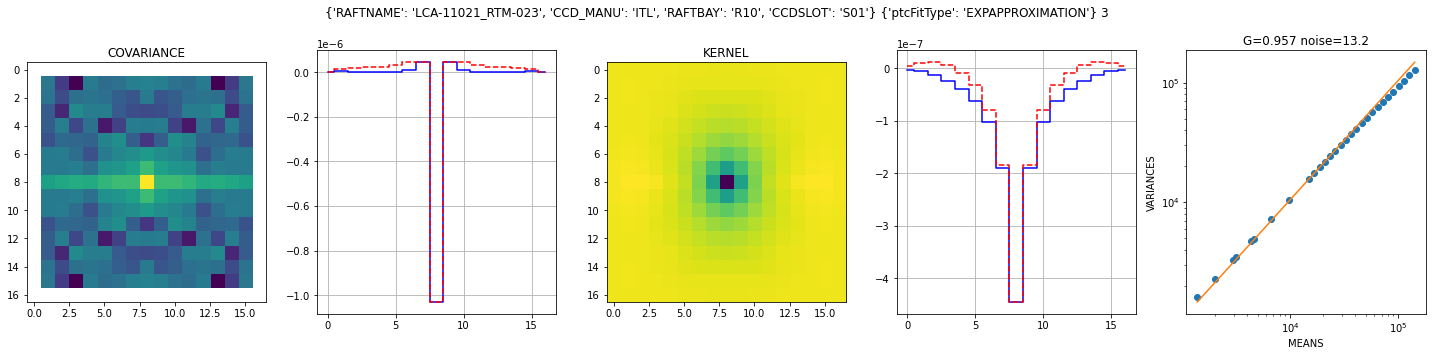

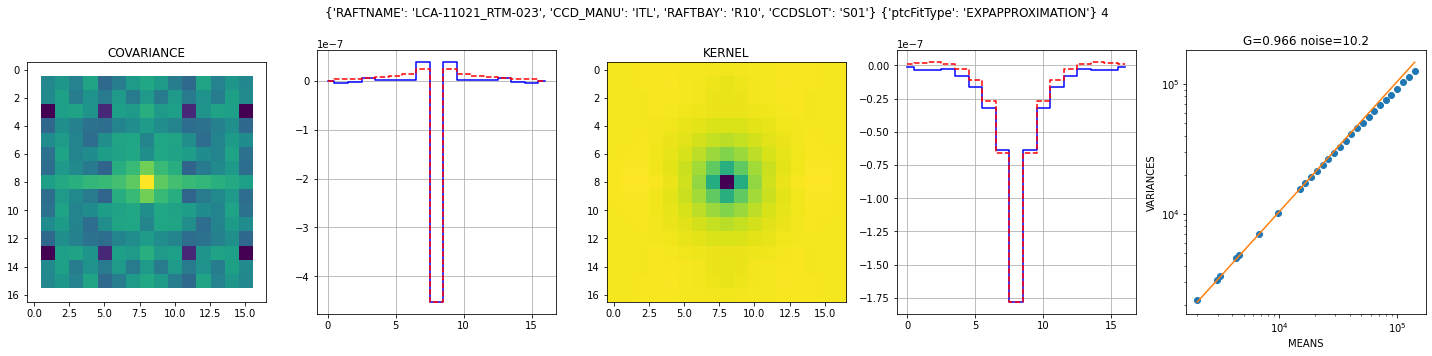

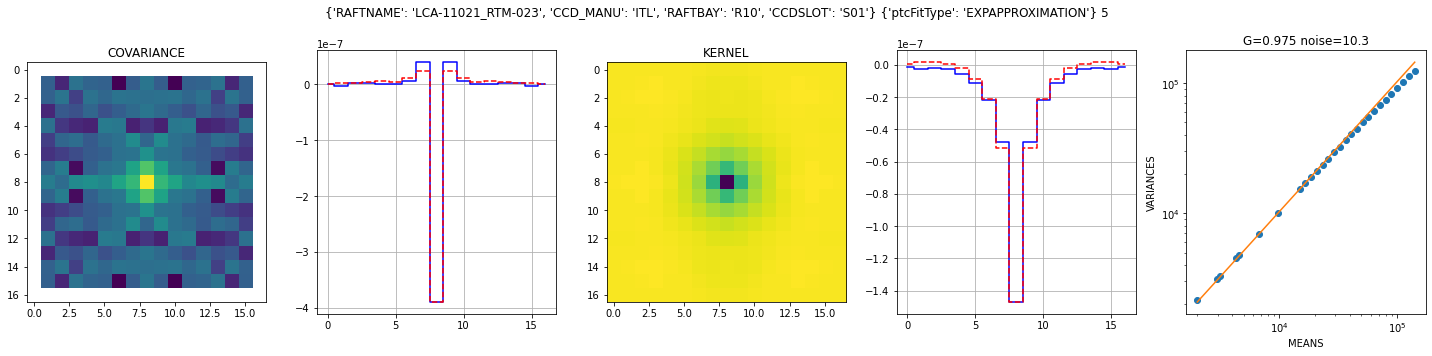

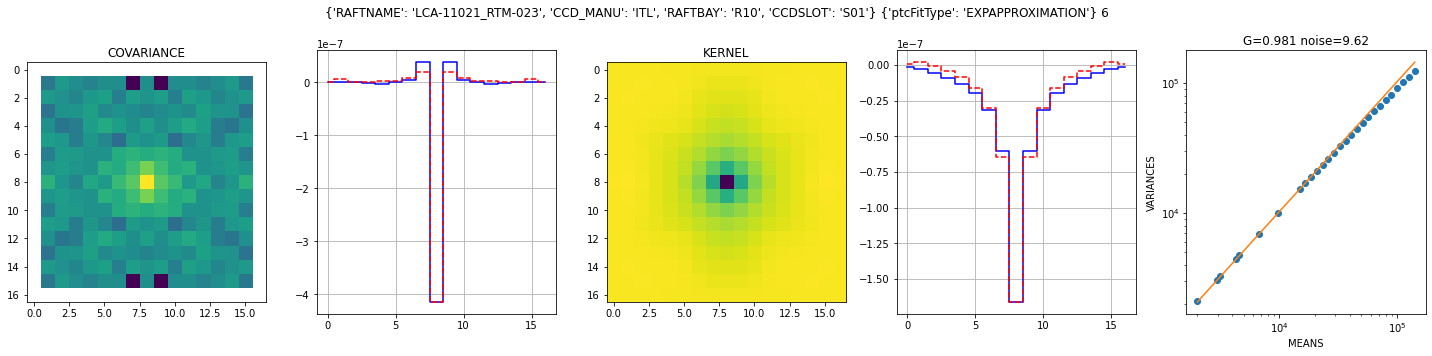

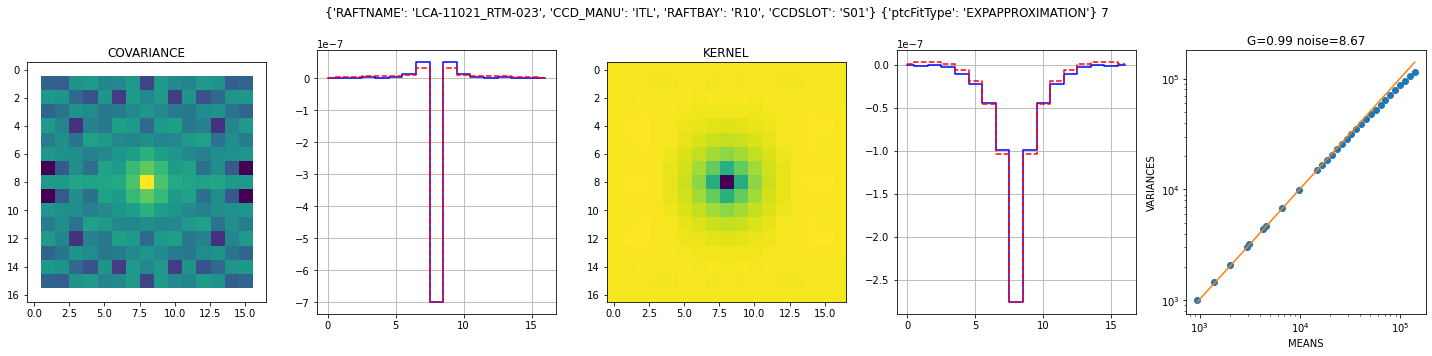

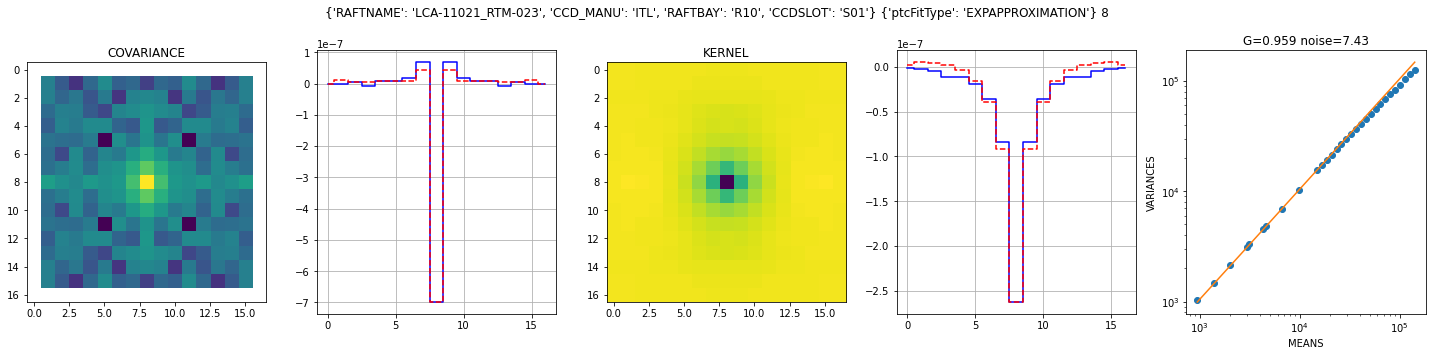

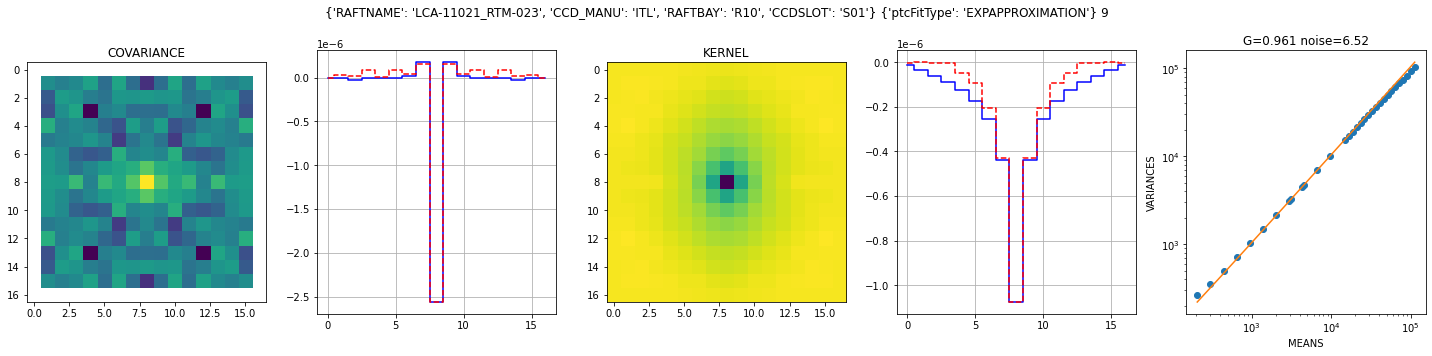

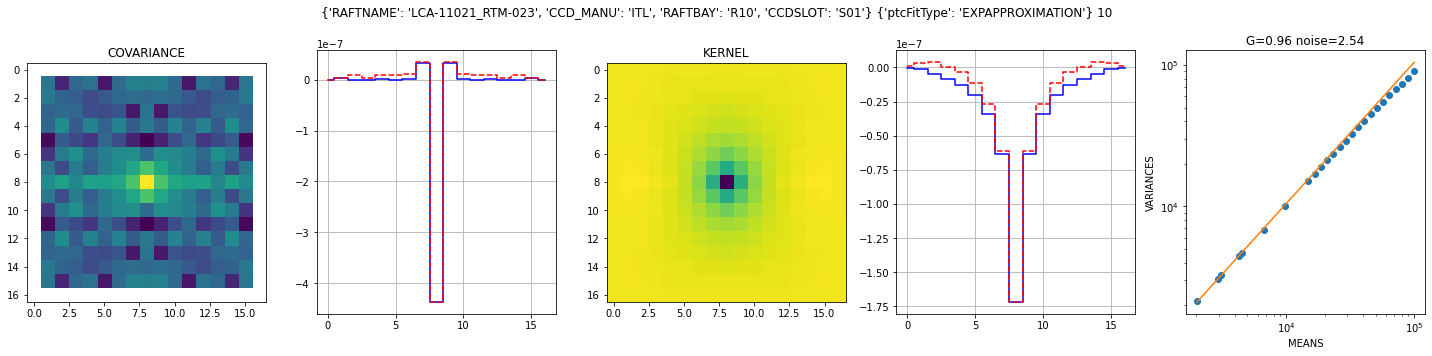

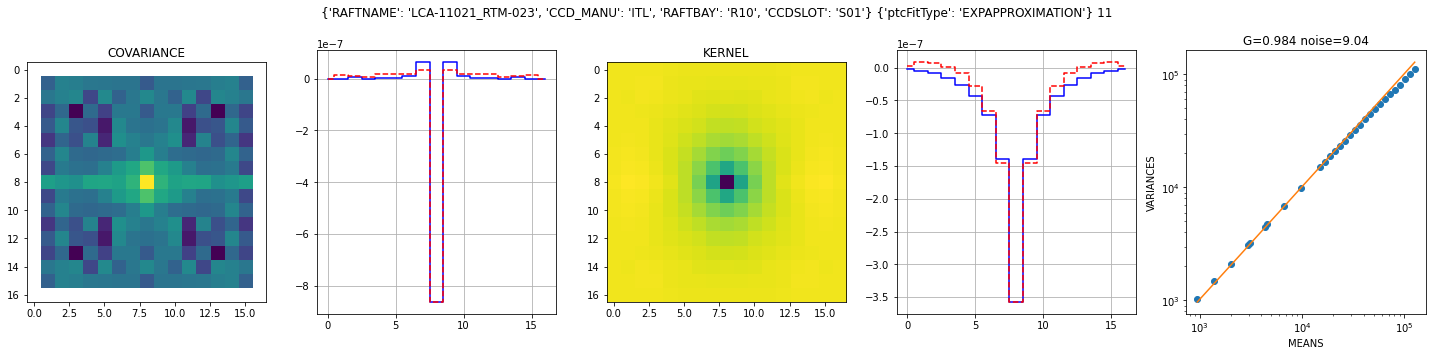

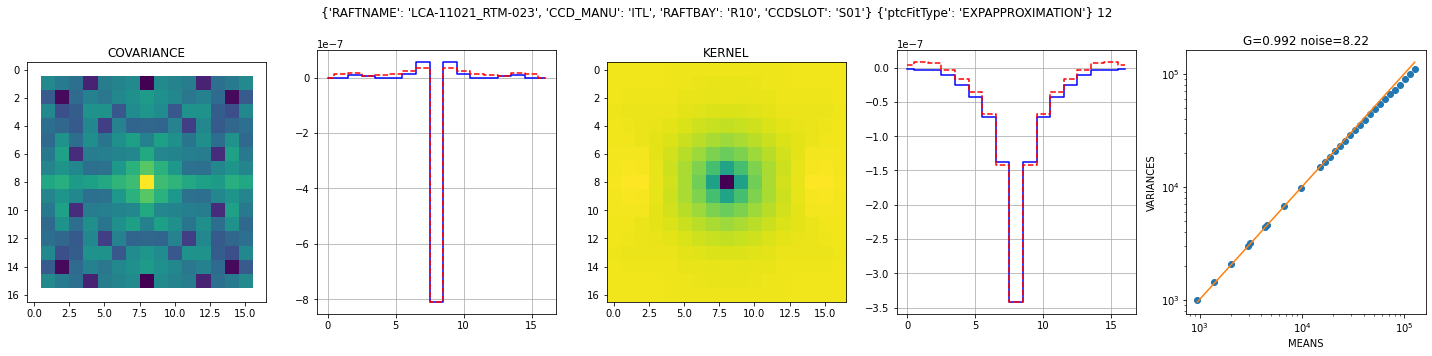

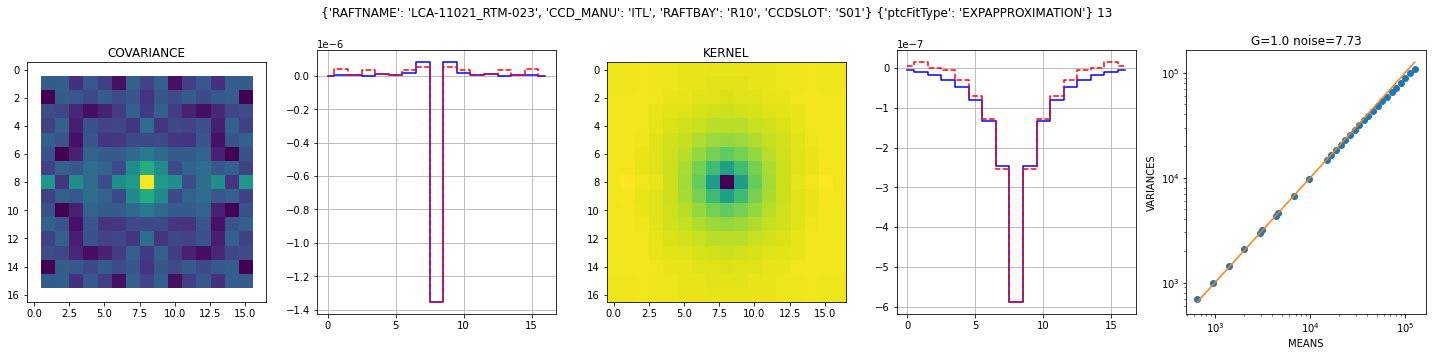

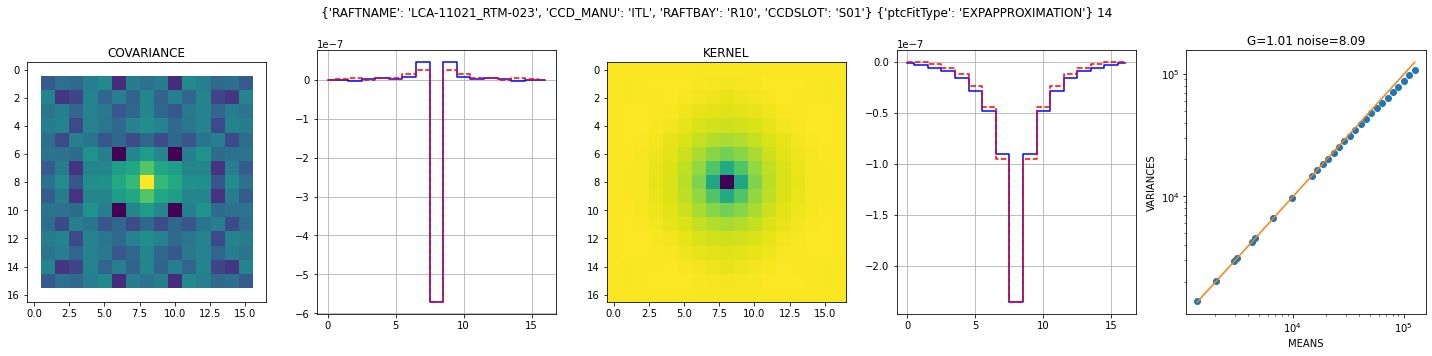

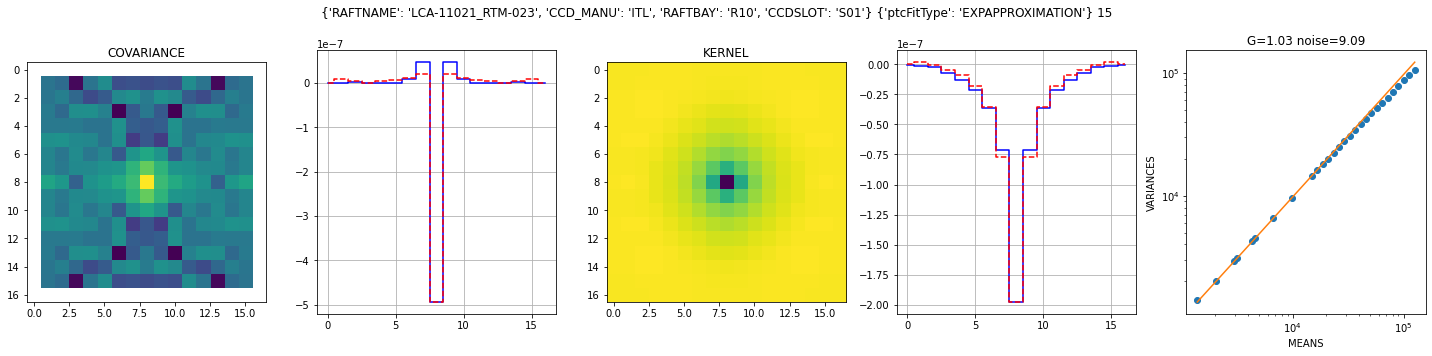

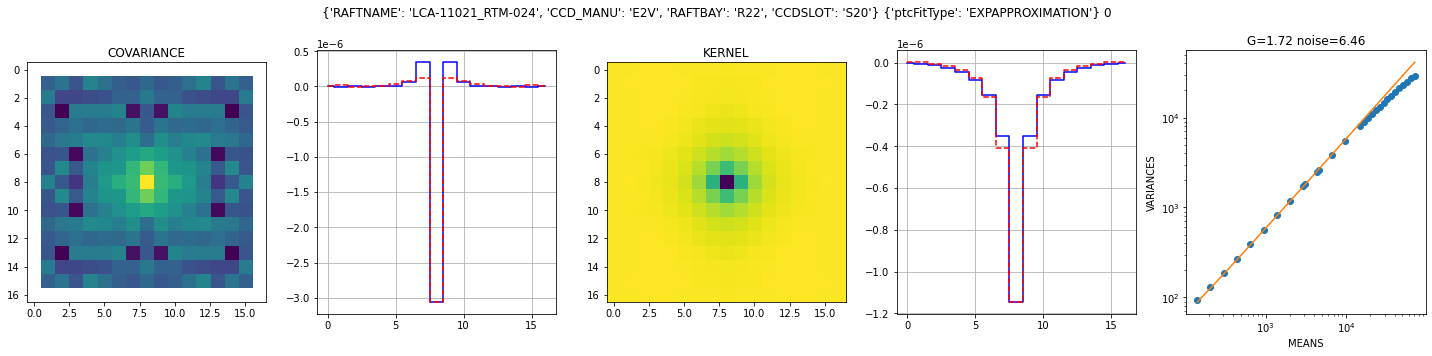

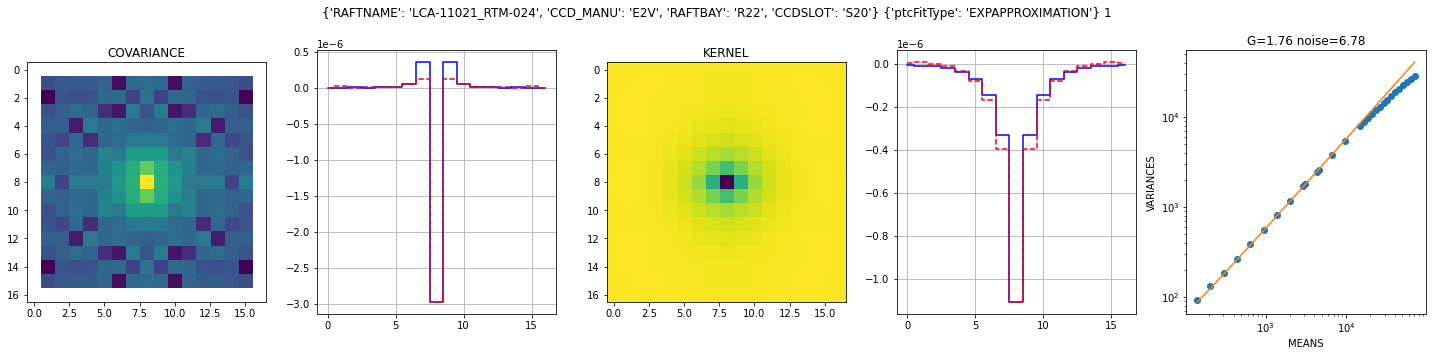

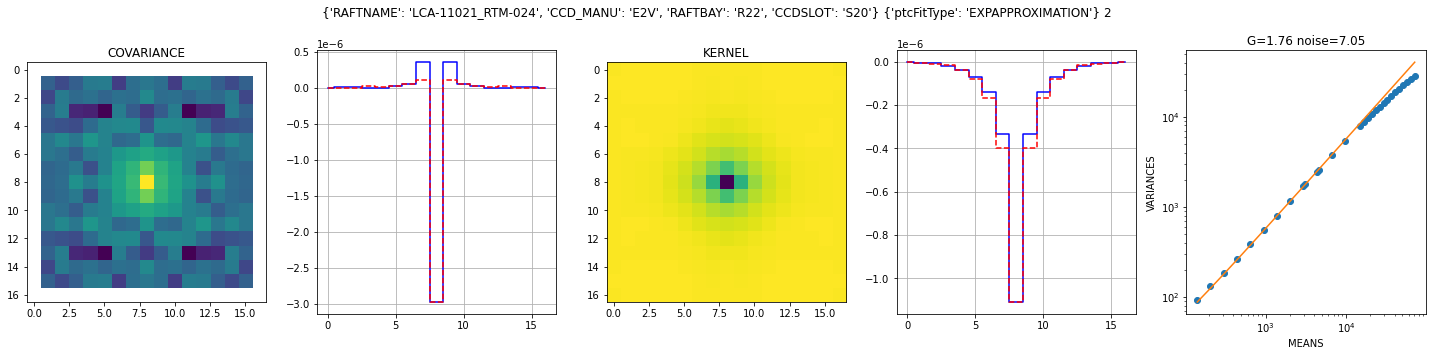

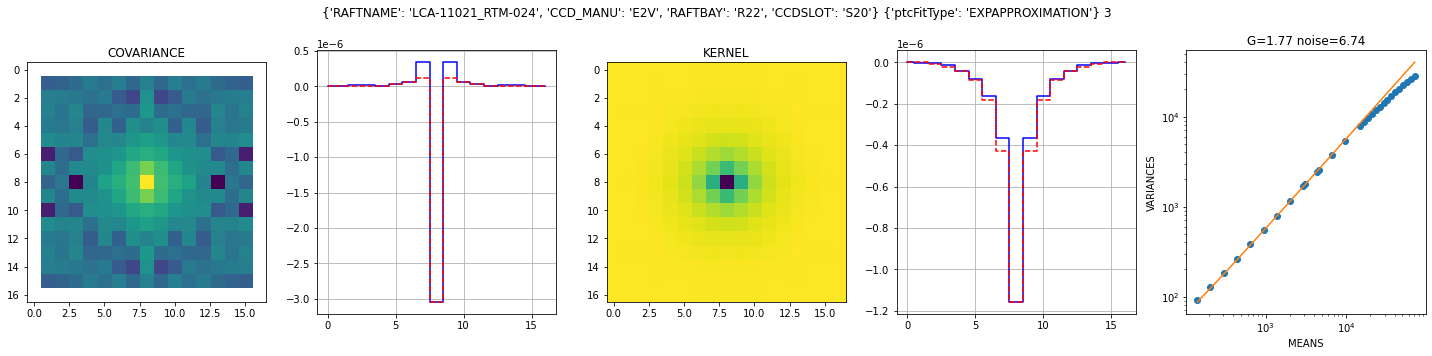

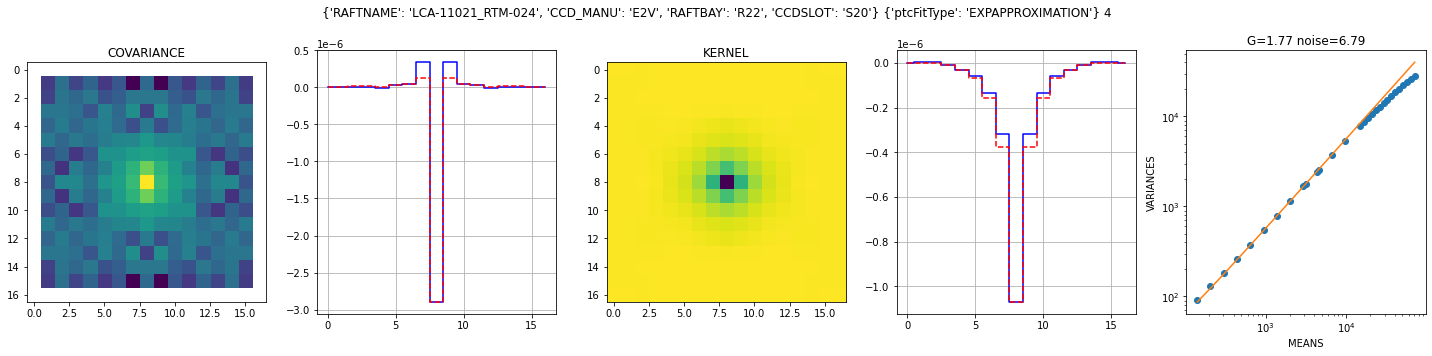

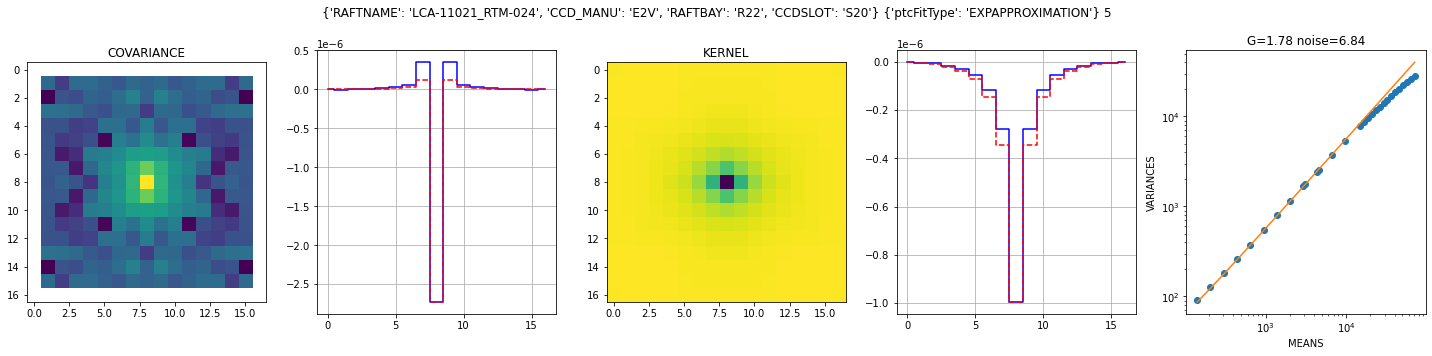

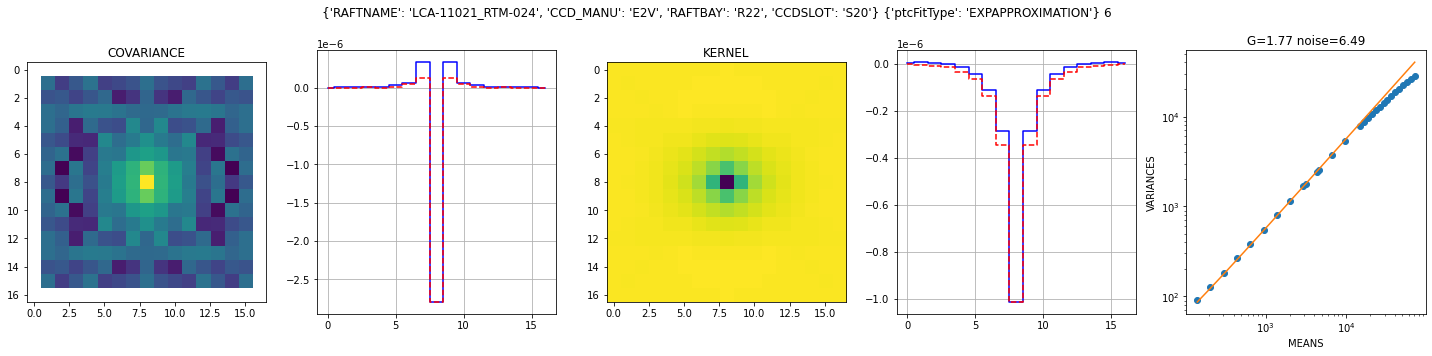

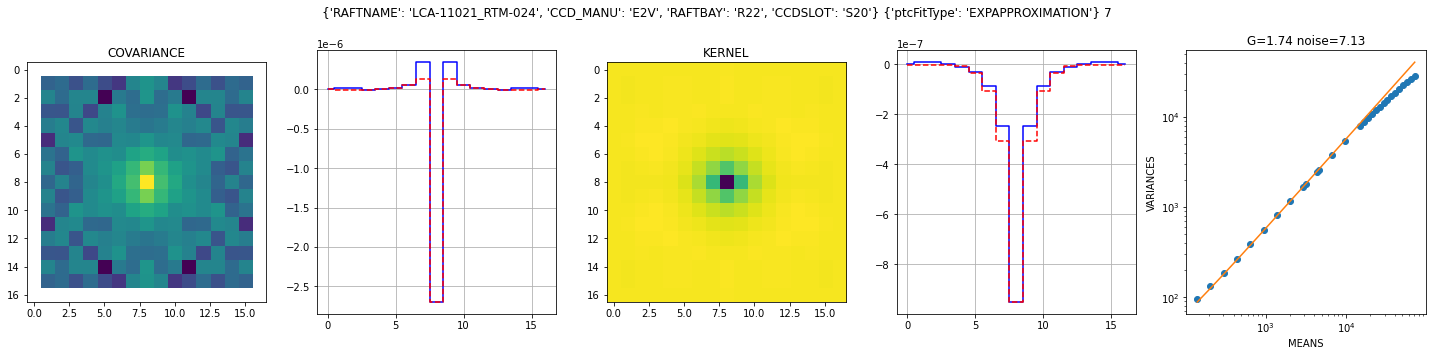

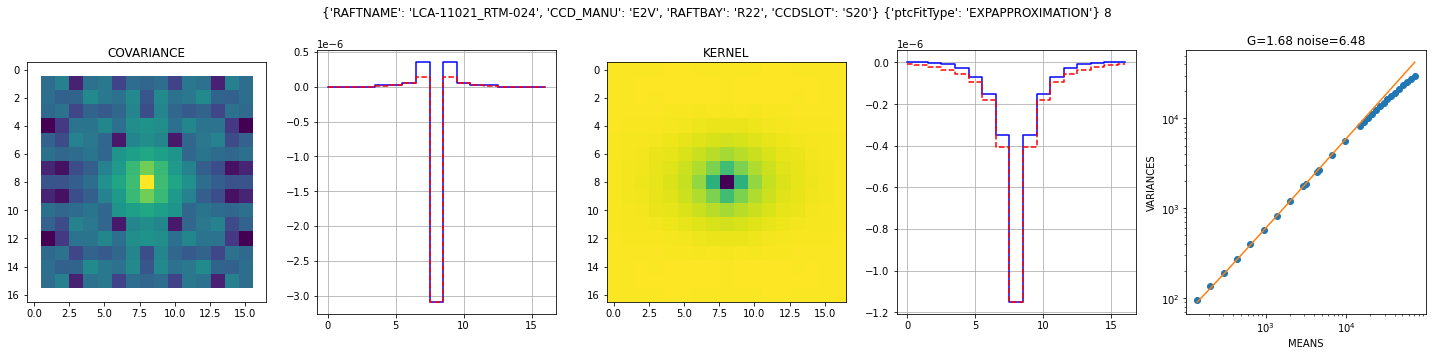

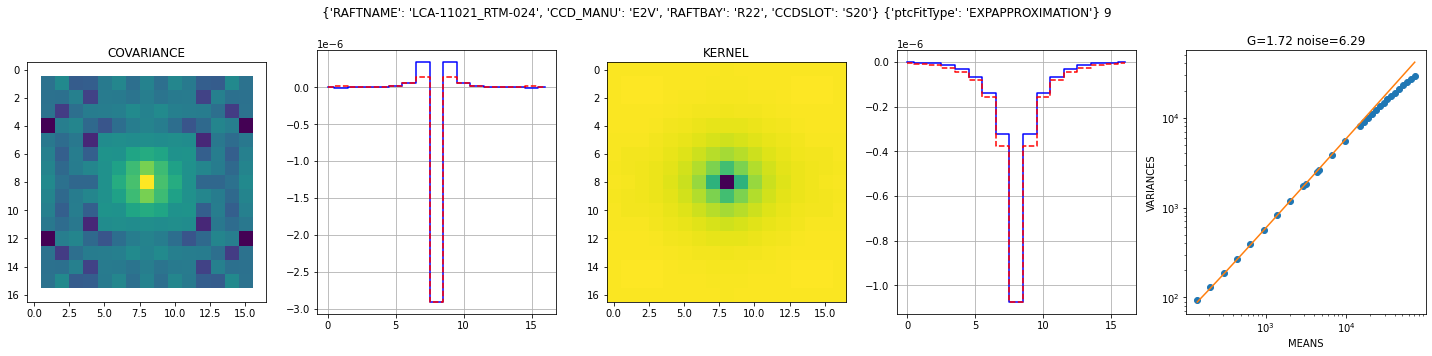

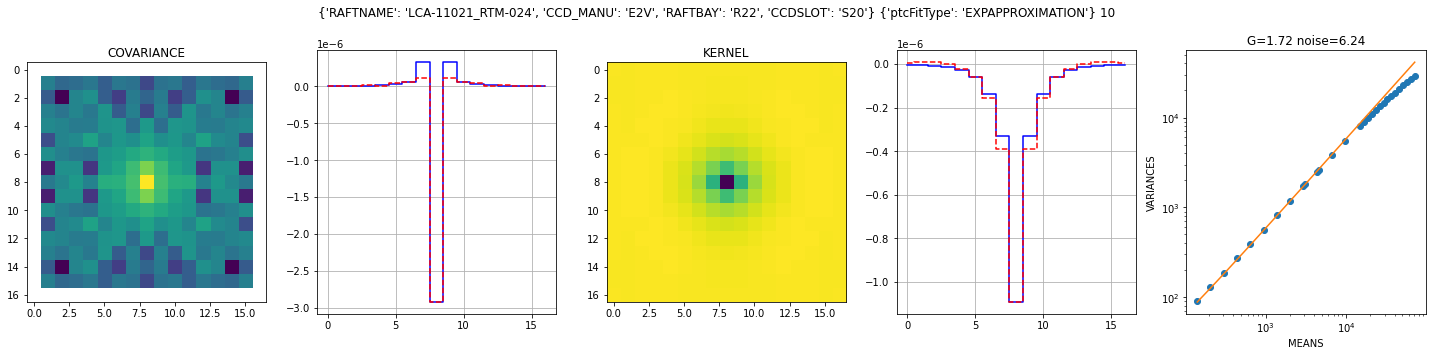

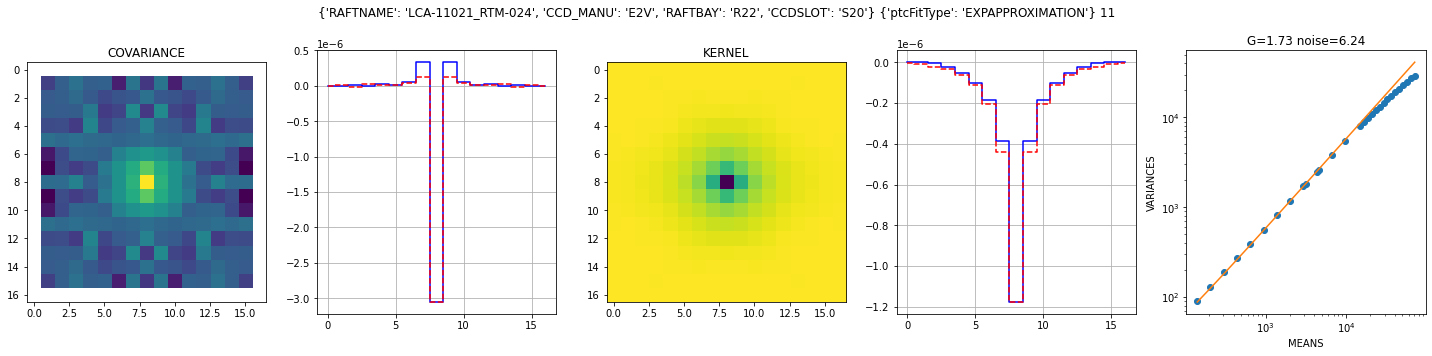

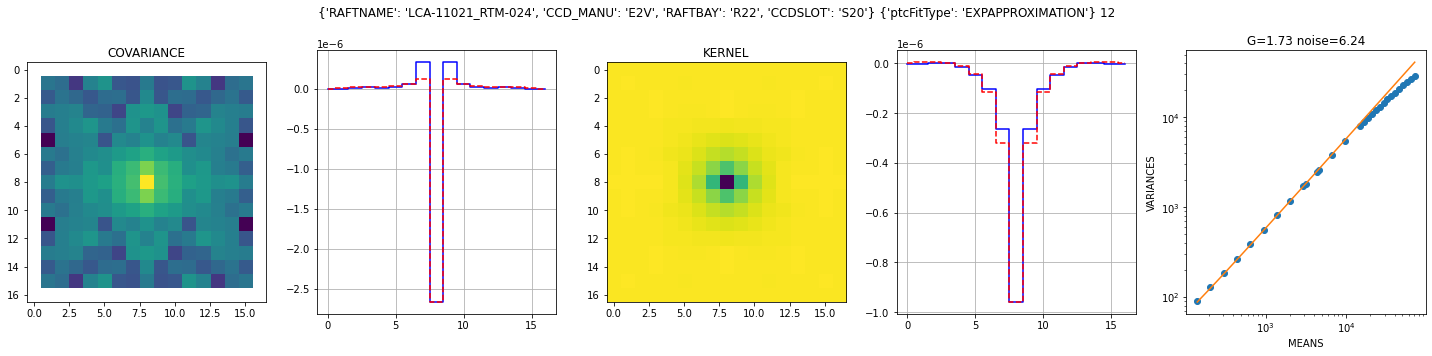

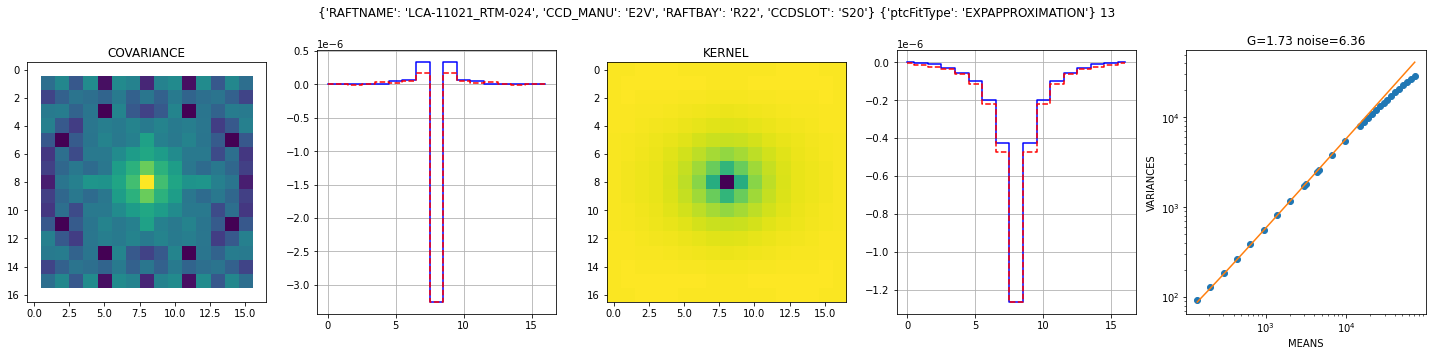

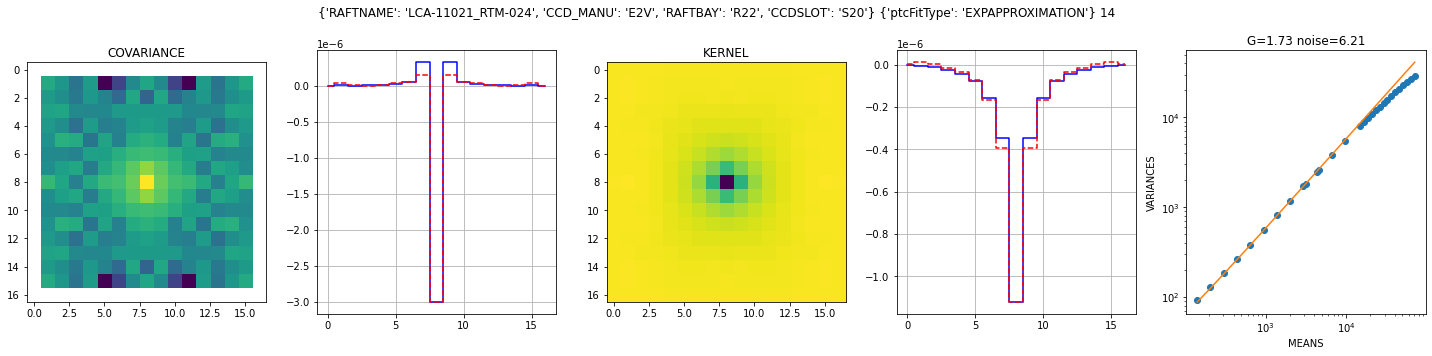

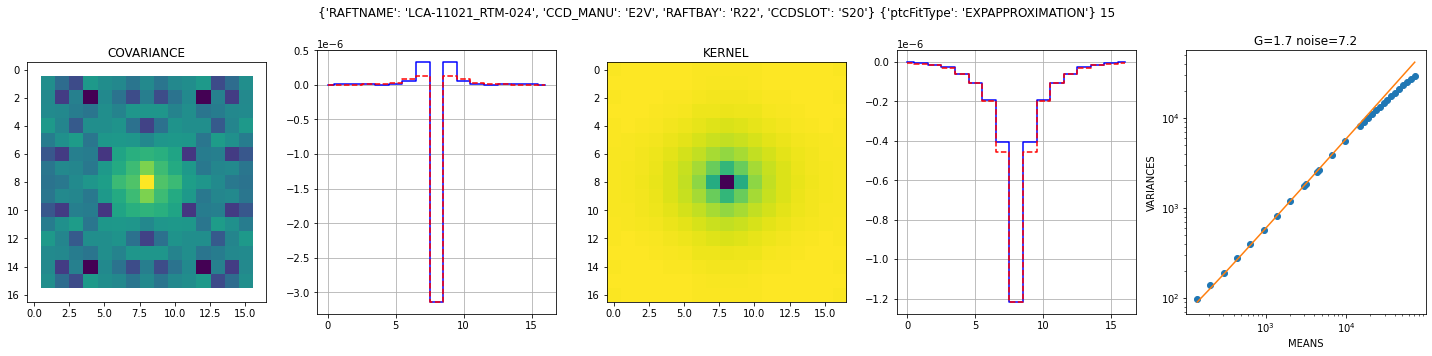

In [5]:
datasetRefs = list(subregistry.queryDatasets(datasetType="ptc",collections=collections[-1]))

for num, adatasetRef in enumerate(datasetRefs):
    ptc = subbutler.get(adatasetRef)
    rawref = list(subregistry.queryDatasets(datasetType="raw",dataId=adatasetRef.dataId))
    print(rawref[0].dataId)
    raw = subbutler.get(rawref[0])
    bfk = BrighterFatterKernelSolveTask()
    bfk.config.forceZeroSum = True
    bfk.config.correlationModelRadius = 3
    new = bfk.run(ptc,[raw],LsstCam().getCamera(),adatasetRef.dataId)
    mkplot(new,
           "{} {}".format(
               { akey:
                raw.getMetadata()[akey] for akey in [ "RAFTNAME","CCD_MANU","RAFTBAY","CCDSLOT"]
               },
               {"ptcFitType": ptc.ptcFitType}
           )
          )

# With the original parameter

{instrument: 'LSSTCam', detector: 29, exposure: 3020111900001, ...}
{instrument: 'LSSTCam', detector: 28, exposure: 3020111900001, ...}


<ipython-input-4-9156dcff43d4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = pylab.subplots(1, 5, figsize=(20,5),facecolor='w')


{instrument: 'LSSTCam', detector: 96, exposure: 3020111900001, ...}


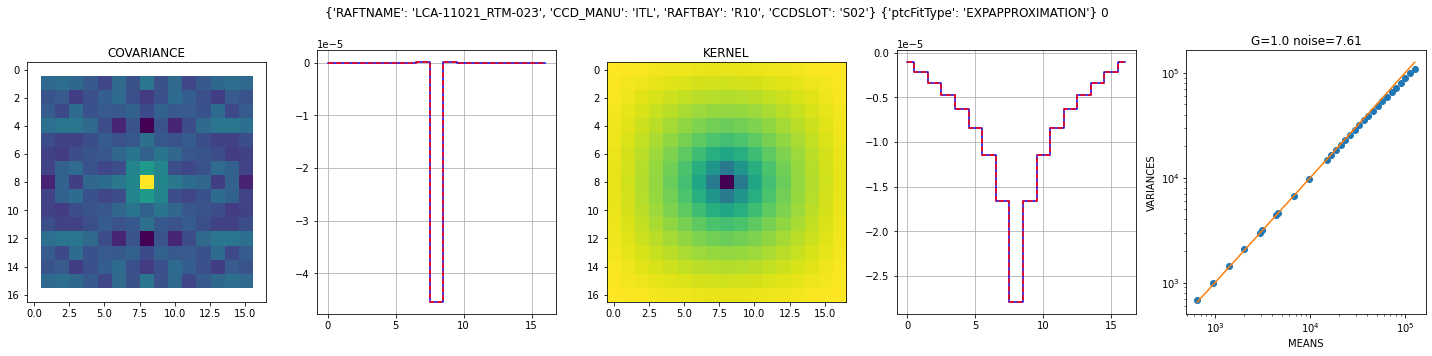

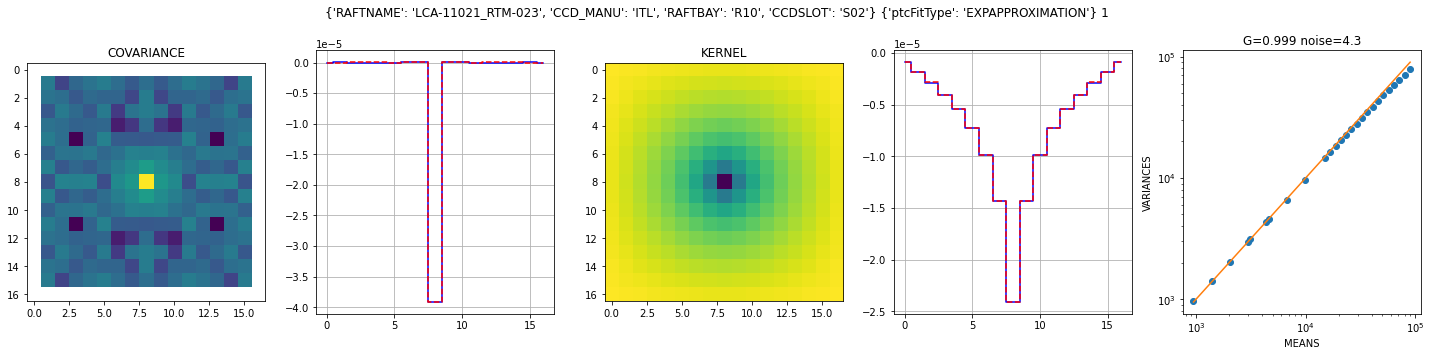

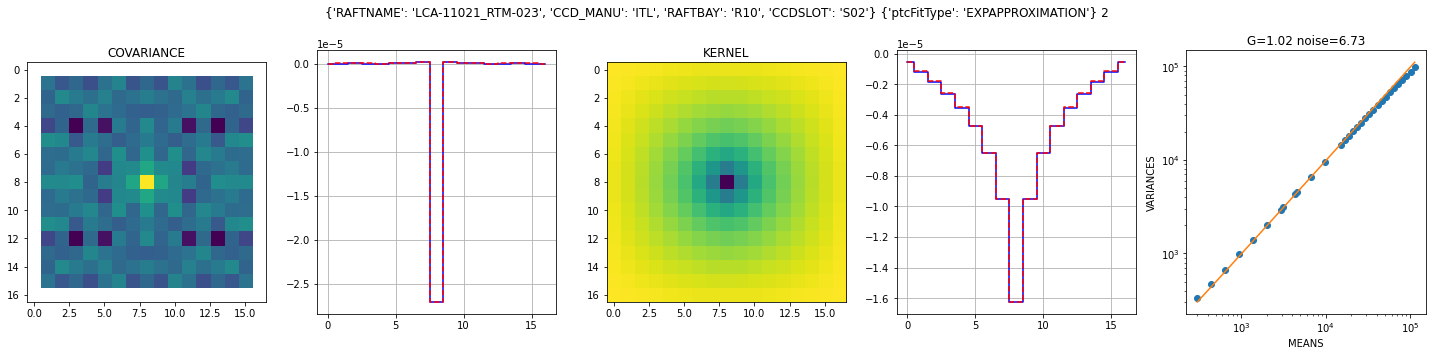

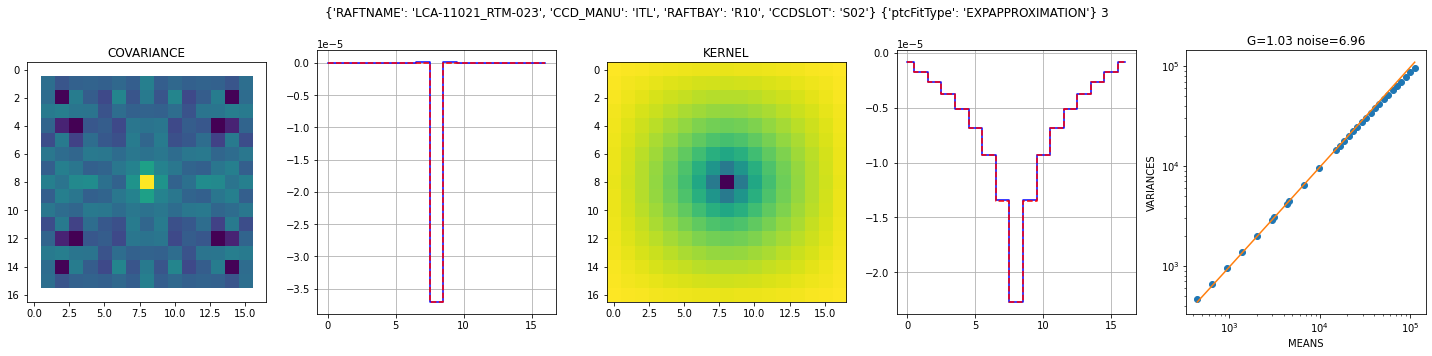

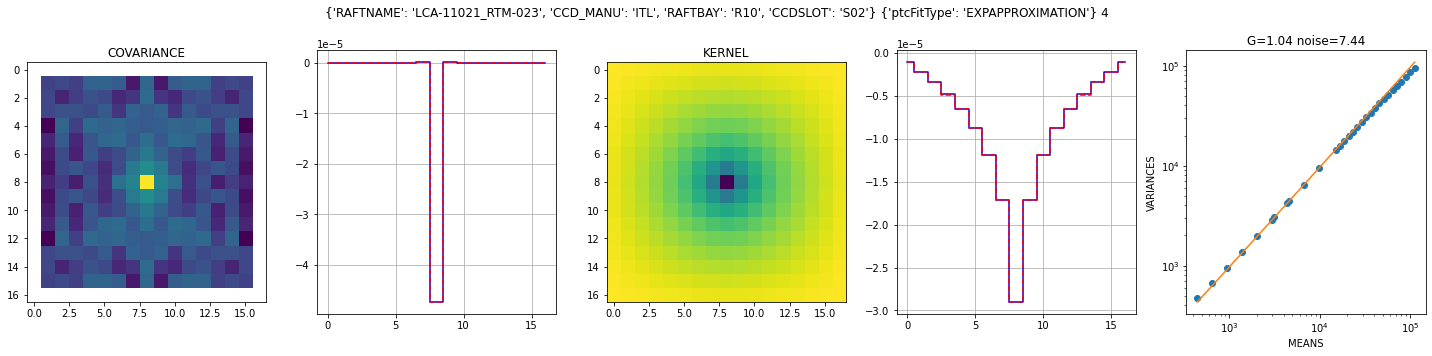

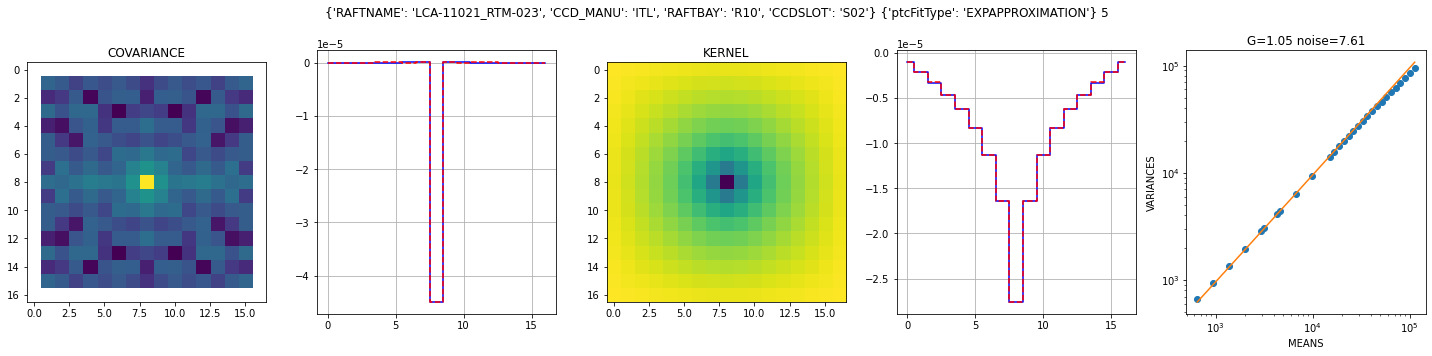

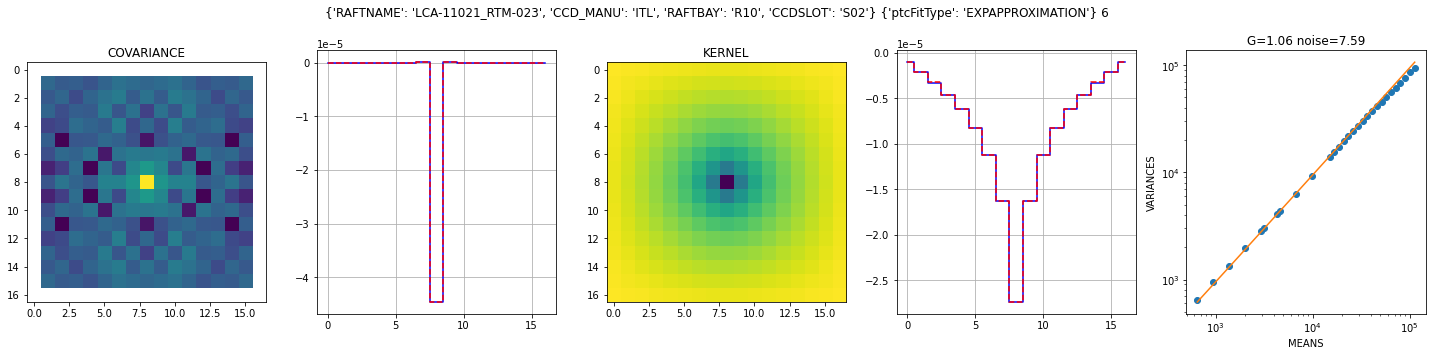

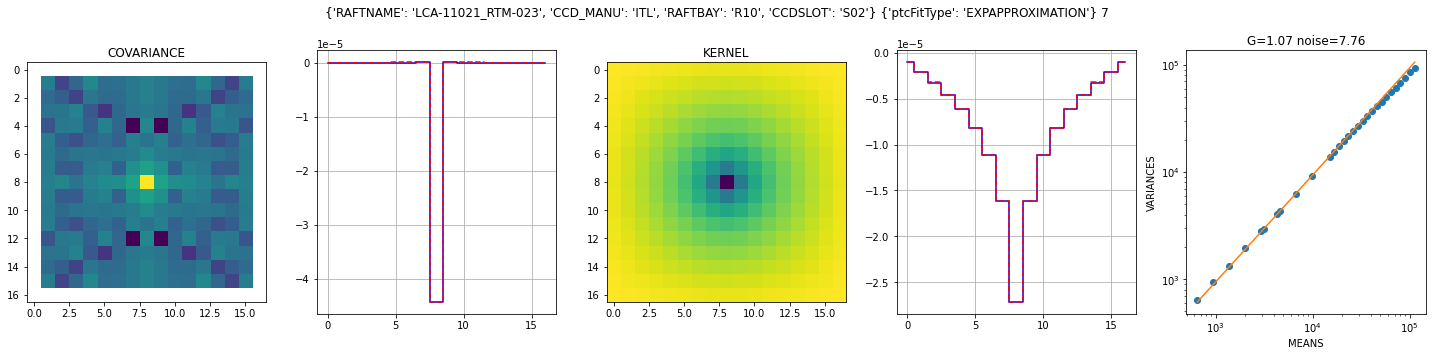

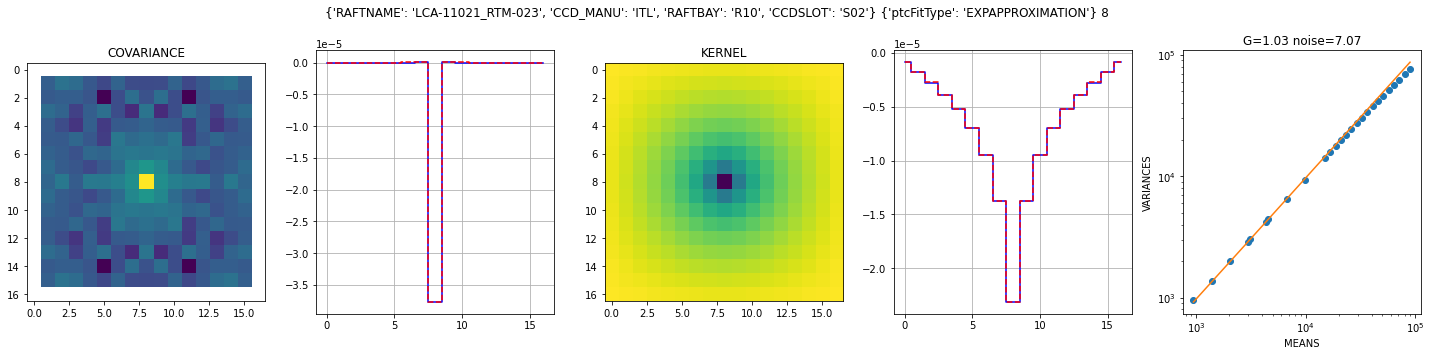

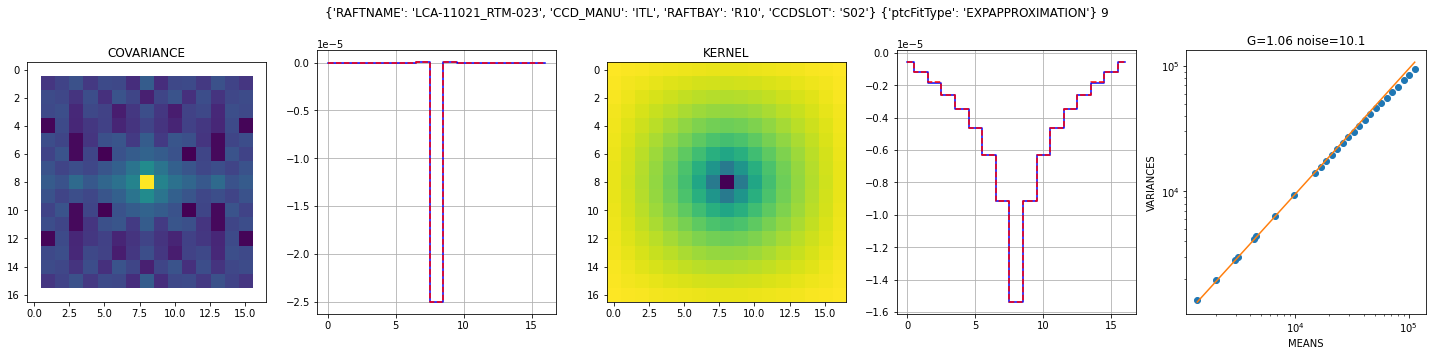

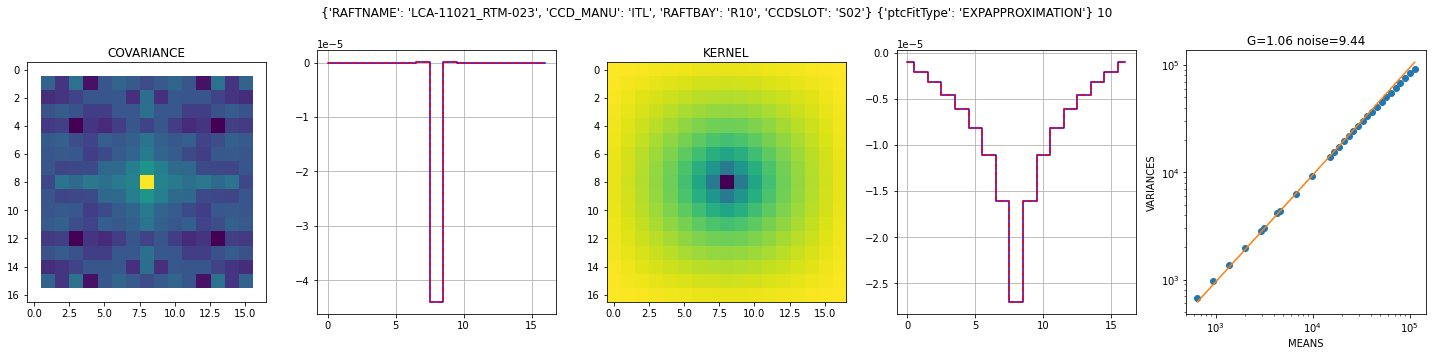

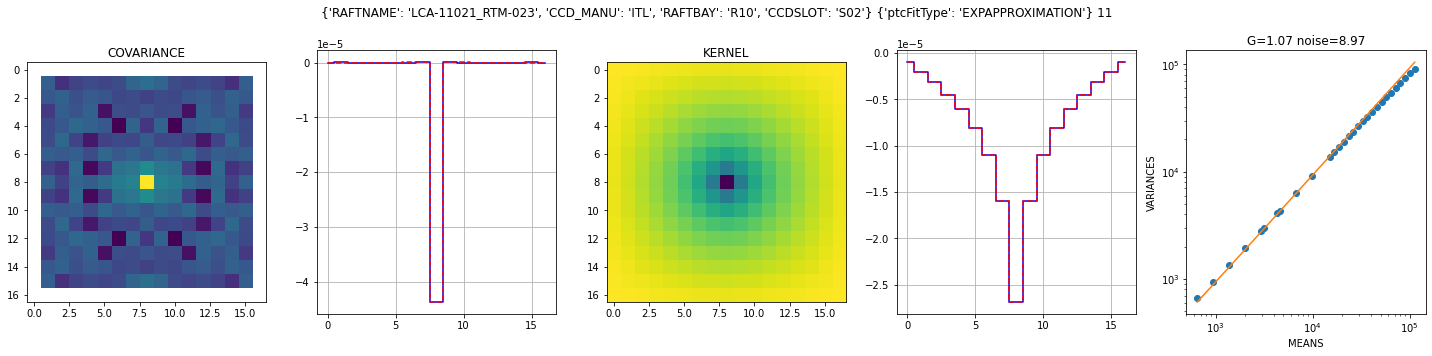

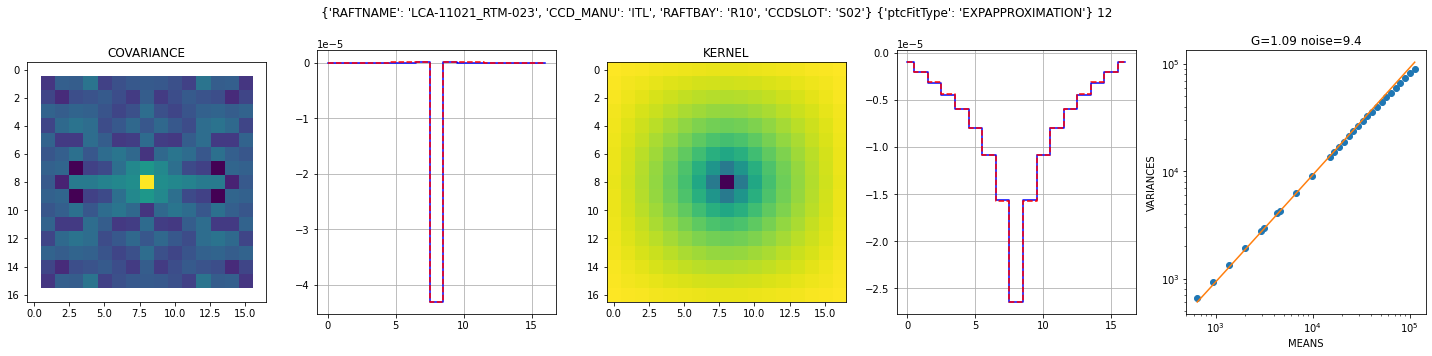

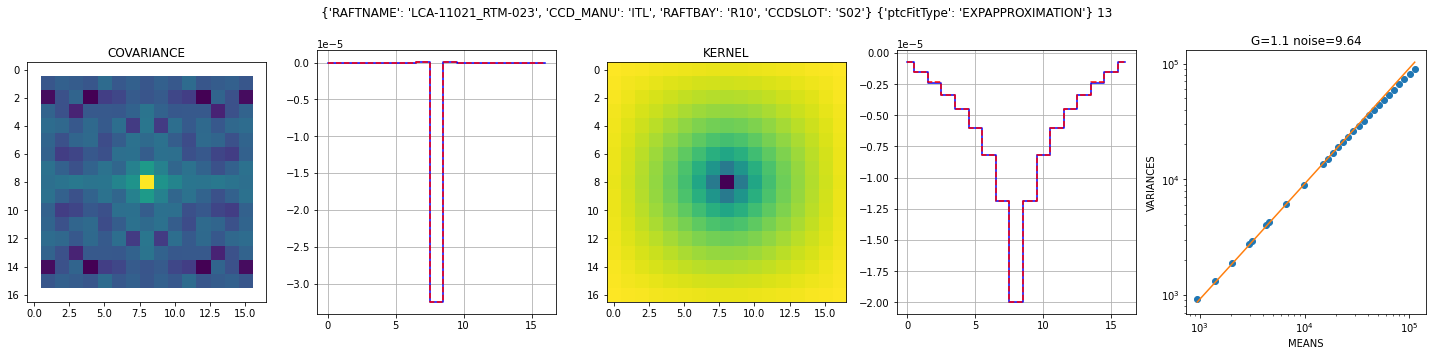

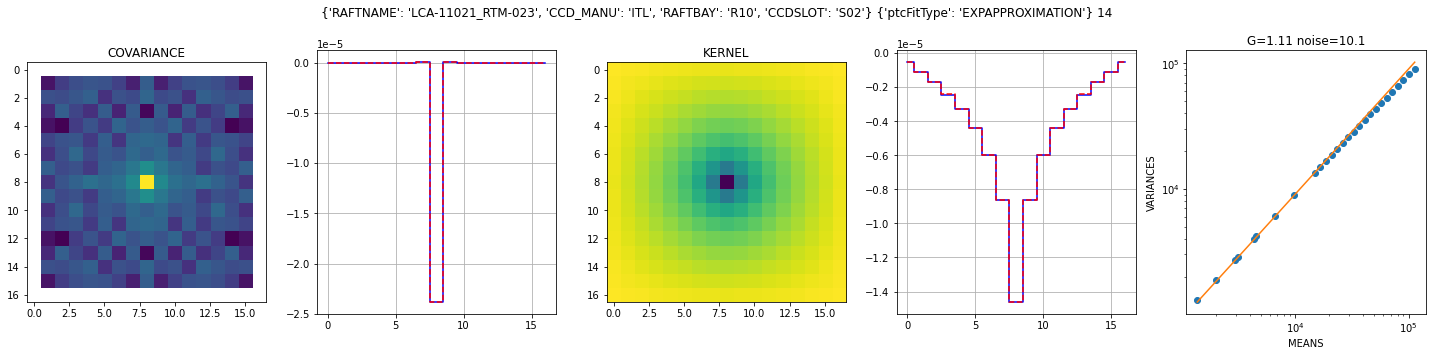

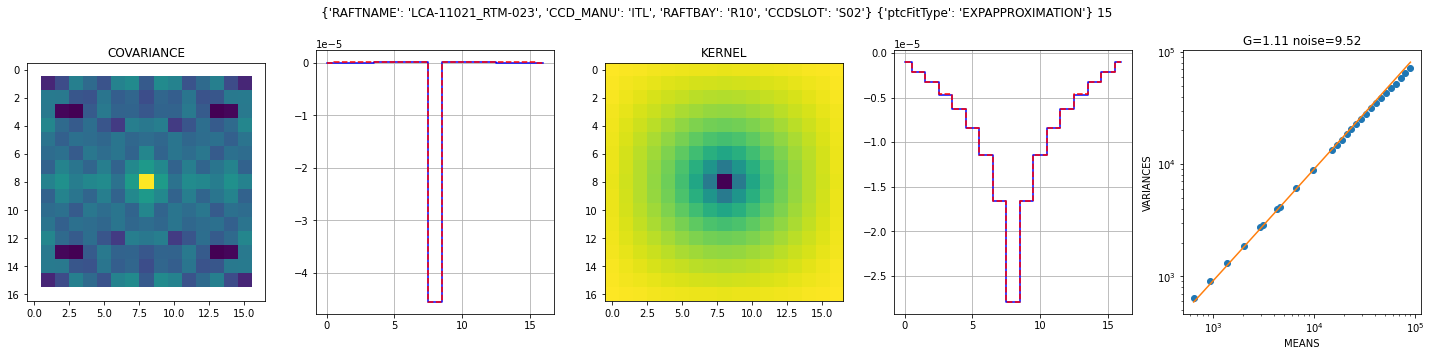

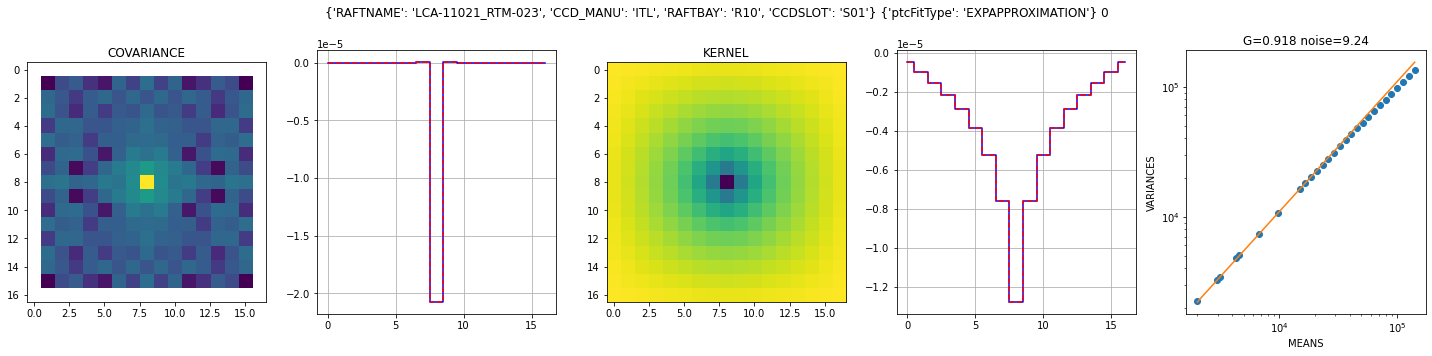

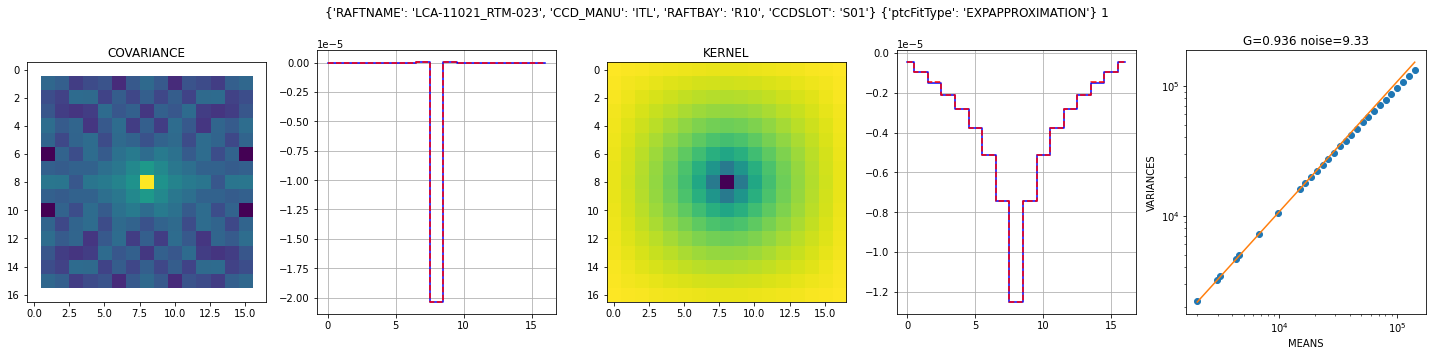

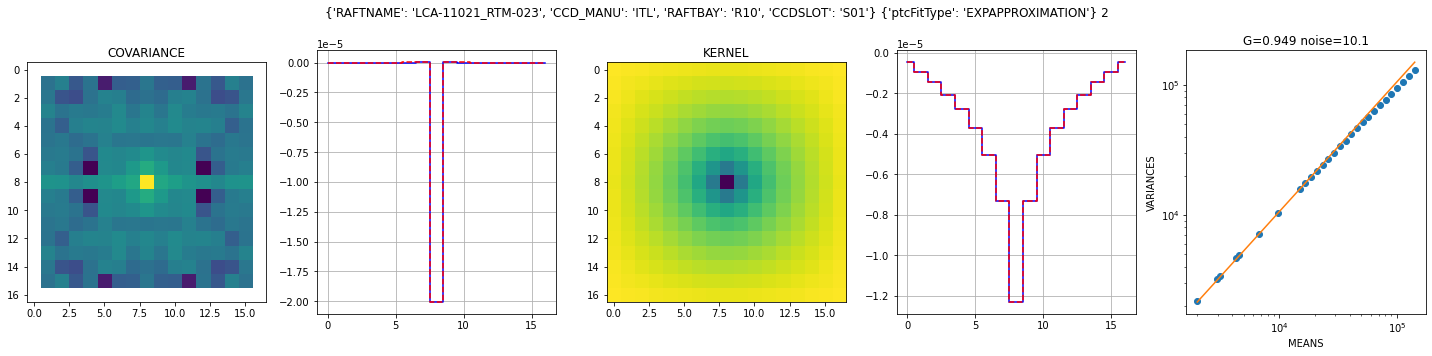

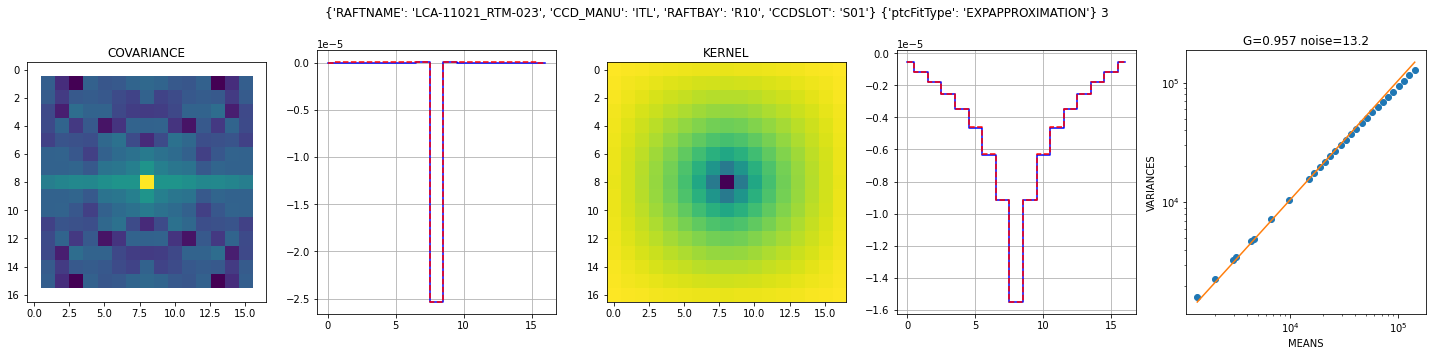

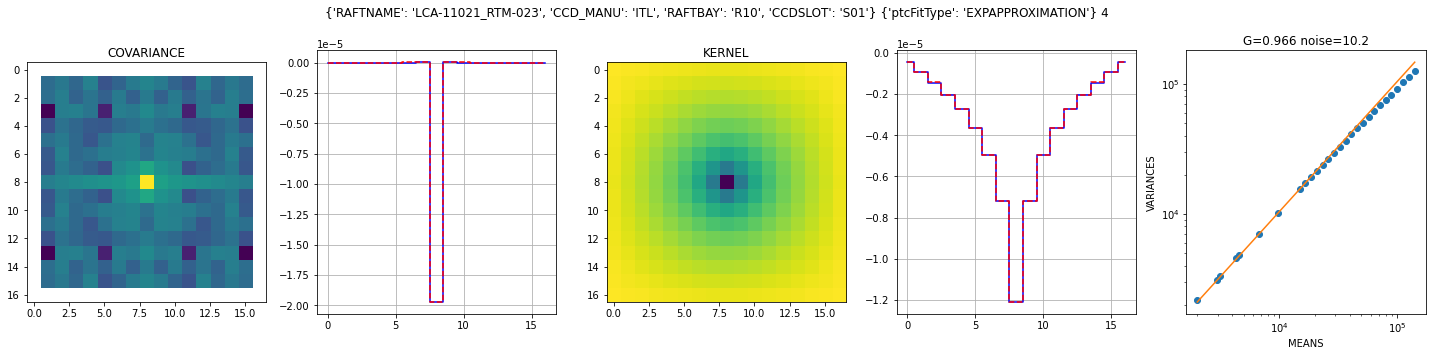

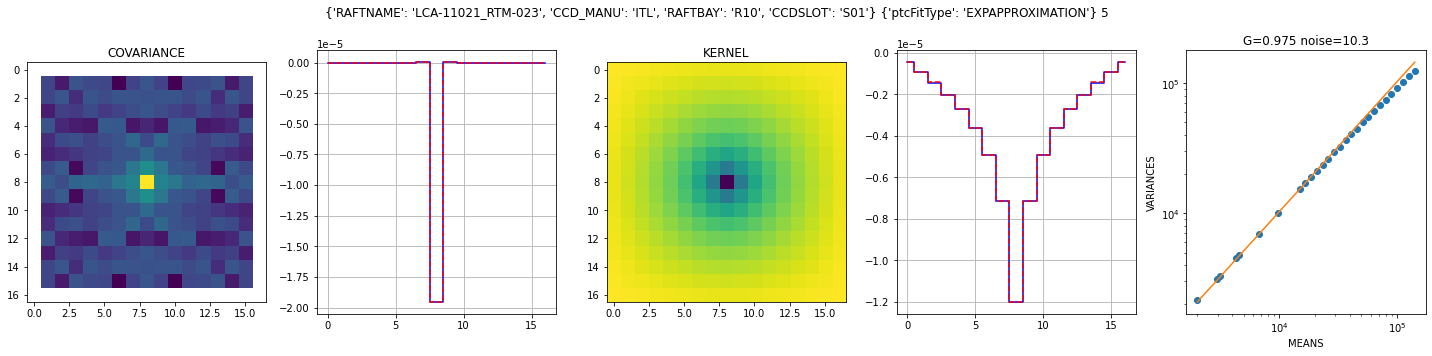

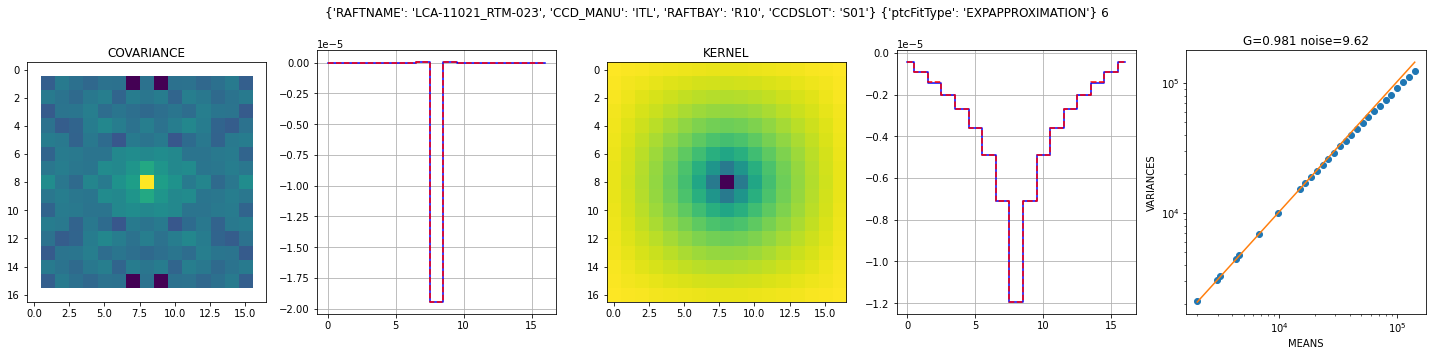

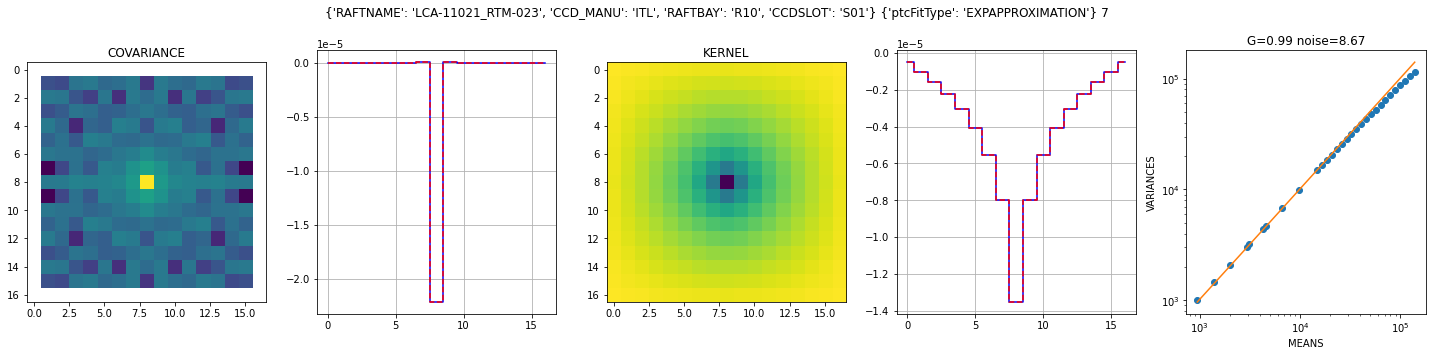

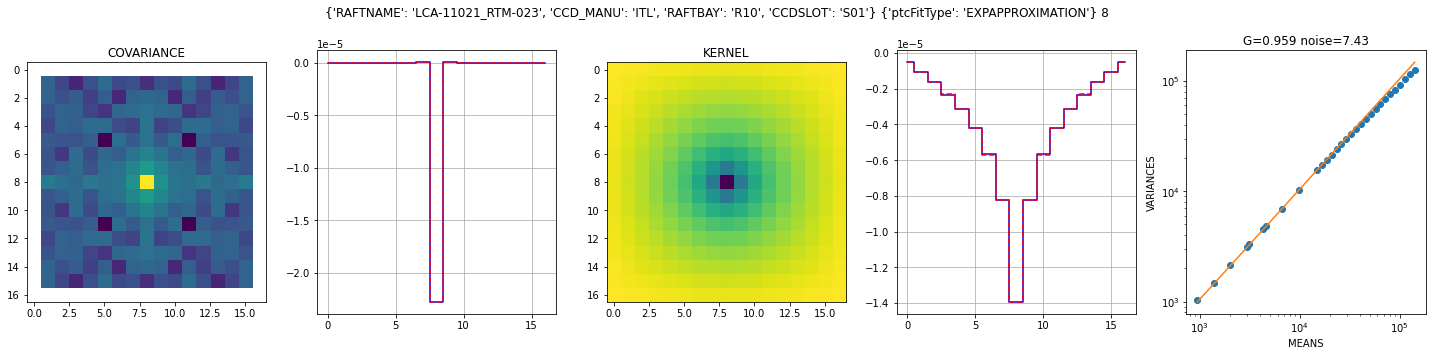

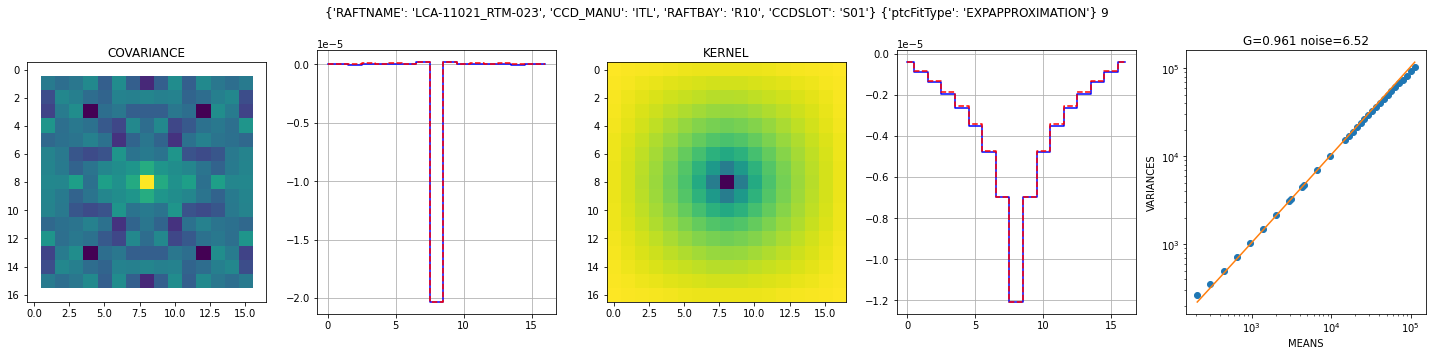

In [ ]:
datasetRefs = list(subregistry.queryDatasets(datasetType="ptc",collections=collections[-1]))

for num, adatasetRef in enumerate(datasetRefs):
    ptc = subbutler.get(adatasetRef)
    rawref = list(subregistry.queryDatasets(datasetType="raw",dataId=adatasetRef.dataId))
    print(rawref[0].dataId)
    raw = subbutler.get(rawref[0])
    bfk = BrighterFatterKernelSolveTask()
#    bfk.config.forceZeroSum = True
#    bfk.config.correlationModelRadius = 3
    new = bfk.run(ptc,[raw],LsstCam().getCamera(),adatasetRef.dataId)
    mkplot(new,
           "{} {}".format(
               { akey:
                raw.getMetadata()[akey] for akey in [ "RAFTNAME","CCD_MANU","RAFTBAY","CCDSLOT"]
               },
               {"ptcFitType": ptc.ptcFitType}
           )
          )

In [ ]:
datasetRefs = list(subregistry.queryDatasets(datasetType="ptc",collections=collections[-1]))
datasetRefs